# Д/З 2.2: построение сетей CNN + FFN
### Выполнила Елизавета Клыкова, БКЛ181
#### Импорт библиотек

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import ast
import random
import numpy as np
import pandas as pd
from nltk import word_tokenize
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import seaborn as sns
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, \
    RandomSampler, SequentialSampler
from torchmetrics import F1
from torchmetrics.functional import f1, recall

In [3]:
seed = 117
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available()\
                              else torch.device('cpu')
DEVICE

device(type='cuda')

 #### Загрузка [датасета](http://study.mokoron.com/)

In [5]:
tweets = pd.read_csv('final_tweets_dataset.tsv', sep='\t')

tweets['tokens'] = tweets['tokens'].apply(
    lambda x: ' '.join(ast.literal_eval(x)))

tweets

,ttext,ttype,tokens
0,"@first_timee хоть я и школота, но поверь, у на...",1,USER хоть я и школота но поверь у нас то же са...
1,"Да, все-таки он немного похож на него. Но мой ...",1,да все таки он немного похож на него но мой ма...
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,rt USER ну ты идиотка я испугалась за тебя
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,rt USER кто то в углу сидит и погибает от голо...
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1,USER вот что значит страшилка d но блин посмот...
...,...,...,...
217435,Но не каждый хочет что то исправлять:( http://...,0,но не каждый хочет что то исправлять URL
217436,скучаю так :-( только @taaannyaaa вправляет мо...,0,скучаю так только USER вправляет мозги но я вс...
217437,"Вот и в школу, в говно это идти уже надо(",0,вот и в школу в говно это идти уже надо
217438,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0,rt USER USER тауриэль не грусти обнял


#### Словари для модели

In [6]:
unique_tokens = Counter()
unique_symbols = Counter()

for text in tqdm(tweets['tokens']):
    tokens = text.split()
    symbols = list(text)
    unique_tokens.update(tokens)
    unique_symbols.update(symbols)

print('Уникальных токенов:', len(unique_tokens),
      '\nУникальных символов:', len(unique_symbols))

  0%|          | 0/217440 [00:00<?, ?it/s]

Уникальных токенов: 180371 
Уникальных символов: 73


In [7]:
token2id = {'PAD': 0}

for token, freq in unique_tokens.most_common():
    if freq >= 5:
        token2id[token] = len(token2id)

In [8]:
id2token = {i: token for token, i in token2id.items()}
len(id2token.values())

31175

In [9]:
symbol2id = {'PAD': 0}

for symbol, freq in unique_symbols.most_common():
    symbol2id[symbol] = len(symbol2id)

In [10]:
id2symbol = {i: symbol for symbol, i in symbol2id.items()}
len(id2symbol.values())

74

## Часть 2: комбинация эмбеддингов и символьных признаков

Решите задачу, используя две следующие архитектуры. Для каждой посчитайте accuracy, precision, recall.

**II. Комбинация эмбеддингов и символьных признаков:** у этой модели два входа, один для эмбеддингов слов (предобученных или обучаемых), из них берем max или mean, делаем вектор для предложения, поверх линейный слой -- получаем вектор X. Другой вход сети для символьного представления слов (это обучаемый Embedding слой, он будет брать на вход batch_size x symbols_len и сопоставлять каждому символу в каждом слове один эмбеддинг). Следующий слой сверточный, примените фильтры разных размеров. Результаты агрегируются с помощью max pooling over time и полученные векторы конкатенируются с вектором X. Далее линейный слой + сигмоида, функция потерь BCELoss.

**Баллы:**

5. Правильно подготовленный класс Dataset для второй архитектуры (теперь вам нужно два словаря (word2id и symbol2id) и две матрицы для кодирования предложения: одна размера batch_size x seq_len, другая batch_size x sybmols_len) -- 2 балла

6. Вторая модель правильно построена и обучается -- 2 балла

7. Для второй модели показано, что качество можно улучшить засчет работы с гиперпараметрами и/или доведения архитектуры (помогло изменение количества/размера фильтров, размера слоя/эмбеддингов, добавили Dropout и спаслись от переобучения, добавили слоев и т.д.) -- 1 балл

8. Сделана попытка анализа предсказаний, на примерах из тестовой выборки показано, какие случаи даются легко, а какие хуже -- 1 балл

### Dataset & DataLoader

In [11]:
class NewTweetsDataset(Dataset):

    def __init__(self, dataset, token2id, symbol2id, DEVICE):
        self.dataset = dataset['tokens'].values
        self.target = dataset['ttype'].values
        self.length = dataset.shape[0]
        self.token2id = token2id
        self.symbol2id = symbol2id
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        tokens = self.dataset[index].split()
        token_ids = torch.LongTensor([self.token2id[token]
                                     for token in tokens
                                     if token in self.token2id])
        symbols = list(self.dataset[index])
        symbol_ids = torch.LongTensor([self.symbol2id[symbol]
                                      for symbol in symbols
                                      if symbol in self.symbol2id])
        y = [self.target[index]]
        return token_ids, symbol_ids, y

    def collate_fn(self, batch):
        token_ids, symbol_ids, y = list(zip(*batch))
        padded_token_ids = pad_sequence(
            token_ids, batch_first=True).to(self.device)
        padded_symbol_ids = pad_sequence(
            symbol_ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_token_ids, padded_symbol_ids, y

In [12]:
train_data, val_data = train_test_split(tweets, test_size=0.2,
                                        random_state=seed,
                                        stratify=tweets['ttype'])

In [13]:
train_dataset = NewTweetsDataset(train_data, token2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset,
                            collate_fn=train_dataset.collate_fn,
                            sampler=train_sampler, batch_size=1024)

In [14]:
val_dataset = NewTweetsDataset(val_data, token2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset,
                          collate_fn=val_dataset.collate_fn,
                          sampler=val_sampler, batch_size=1024)

### Word&Symbol модель
- Два входа: один для эмбеддингов слов (предобученных или обучаемых), другой для символьного представления слов
- Эмбеддинги слов: берем max или mean, делаем вектор для предложения, поверх линейный слой -- получаем вектор X
- Символьное представление слов: это обучаемый Embedding слой, он берет на вход batch_size x symbols_len и сопоставляет каждому символу в каждом слове один эмбеддинг
- Следующий слой сверточный, примените фильтры разных размеров
- Результаты агрегируются с помощью max pooling over time
- Полученные векторы конкатенируются с вектором X
- Далее линейный слой + сигмоида
- Функция потерь BCELoss

Поскольку в первой части модель с FastText-эмбеддингами слов не показала значимых отличий, не будем усложнять архитектуру и передавать их во вторую модель. **Дисклеймер: в принтах написано "модель с фасттекст-эмбеддингами", потому что я копировала из прошлой тетрадки и не вспомнила, что в эту модель не добавляла фасттекст.**

In [15]:
class WS_CNN(nn.Module):

    def __init__(self, token_vocab_size, symbol_vocab_size,
                 token_embedding_dim, symbol_embedding_dim):

        super().__init__()

        # эмбеддинг-слой для слов
        self.token_embedding = nn.Embedding(token_vocab_size,
                                            token_embedding_dim)
        self.token_hidden = nn.Linear(in_features=token_embedding_dim,
                                      out_features=100)

        # эмбеддинг-слой для символов
        self.symbol_embedding = nn.Embedding(symbol_vocab_size,
                                             symbol_embedding_dim)
        # биграммная свертка
        self.symbol_bigrams = nn.Conv1d(in_channels=symbol_embedding_dim,
                                        out_channels=100, kernel_size=2,
                                        padding='same')
        # триграммная свертка
        self.symbol_trigrams = nn.Conv1d(in_channels=symbol_embedding_dim,
                                         out_channels=80, kernel_size=3,
                                         padding='same')

        self.hidden = nn.Linear(in_features=280, out_features=1)
        self.relu = nn.ReLU()
        self.out = nn.Sigmoid()

    def forward(self, token_seq, symbol_seq):

        # вектор слов
        embedded_tokens = torch.mean(self.token_embedding(token_seq), dim=1)
        token_vector = self.relu(self.token_hidden(embedded_tokens))

        # символьные эмбеддинги
        embedded_symbols = self.symbol_embedding(symbol_seq)
        embedded_symbols = embedded_symbols.transpose(1, 2)

        # сверточные слои
        feature_map_bigrams = self.relu(self.symbol_bigrams(embedded_symbols))
        feature_map_trigrams = self.relu(
            self.symbol_trigrams(embedded_symbols))

        # пулинг
        pooling1 = feature_map_bigrams.max(2)[0]
        pooling2 = feature_map_trigrams.max(2)[0]

        # конкатенация всего
        concat = torch.cat((pooling1, pooling2, token_vector), 1)

        # линейный слой + сигмоида
        logits = self.hidden(concat)
        logits = self.out(logits)

        return logits

In [16]:
def train(model, iterator, optimizer, criterion, n_epoch):

    progress_bar = tqdm(total=len(train_iterator.dataset),
                        desc='Epoch {}'.format(n_epoch + 1))

    epoch_losses = []  # для подсчета среднего лосса на всех батчах
    epoch_metrics = []
    model.train()  # ставим модель в обучение

    for i, (texts, symbols, ys) in enumerate(iterator):  # итерация по батчам

        optimizer.zero_grad()  # обнуляем градиенты
        preds = model(texts, symbols)  # прогоняем данные через модель
        loss = criterion(preds, ys)  # считаем значение функции потерь
        loss.backward()  # считаем градиенты
        optimizer.step()  # обновляем веса

        # сохраняем значения лосс и f1
        epoch_losses.append(loss.item())
        batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
        epoch_metrics.append(batch_metric.cpu().numpy())

        if (i + 1) % int(len(iterator) / 5) == 0:
            print('Train loss: {}, Train f1: {}'.format(
                np.mean(epoch_losses), np.mean(epoch_metrics)))

        progress_bar.update(texts.shape[0])

    progress_bar.close()

    # возвращаем список (потом построим график и посчитаем среднее)
    return epoch_losses, epoch_metrics

In [17]:
def evaluate(model, iterator, criterion, n_epoch):

    epoch_losses = []
    epoch_metrics = []
    model.eval()

    with torch.no_grad():

        for i, (texts, symbols, ys) in enumerate(iterator):
            preds = model(texts, symbols)  # делаем предсказания на тесте
            loss = criterion(preds, ys)  # считаем значения лосса

            # сохраняем значения лосса и f1
            epoch_losses.append(loss.item())
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metrics.append(batch_metric.cpu().numpy())

            if (i + 1) % int(len(iterator) / 5) == 0:
                print('Val loss: {}, Val f1: {}'.format(
                    np.mean(epoch_losses), np.mean(epoch_metrics)))

    # возвращаем список (потом построим график и посчитаем среднее)
    return epoch_losses, epoch_metrics

In [18]:
def train_and_evaluate(model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=5):
    losses_train = []
    f1s_train = []
    losses_eval = []
    f1s_eval = []

    for n_epoch in range(epochs):

        print('\nTraining...')
        train_losses, train_f1s = train(model, train_iterator,
                                        optimizer, criterion, n_epoch)
        losses_train.append(train_losses)
        f1s_train.append(train_f1s)

        print('\nValidating...\n')
        test_losses, test_f1s = evaluate(model, val_iterator,
                                         criterion, n_epoch)
        losses_eval.append(test_losses)
        f1s_eval.append(test_f1s)

    return losses_train, losses_eval, f1s_train, f1s_eval

In [19]:
ws_model = WS_CNN(len(token2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(ws_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

cnn_model = ws_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [20]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(ws_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\conv.py:297: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv1d(input, weight, bias, self.stride,


Train loss: 0.6914620644905988, Train f1: 0.5243464112281799
Train loss: 0.6820039337172228, Train f1: 0.5733655095100403
Train loss: 0.6732996006806692, Train f1: 0.5970837473869324
Train loss: 0.6642006140421418, Train f1: 0.6150277853012085
Train loss: 0.6548654230201946, Train f1: 0.6271712779998779

Validating...

Val loss: 0.6085179820656776, Val f1: 0.6948248744010925
Val loss: 0.6077939867973328, Val f1: 0.6962583065032959
Val loss: 0.6074171041448911, Val f1: 0.695411205291748
Val loss: 0.6081634275615215, Val f1: 0.6926334500312805
Val loss: 0.607946552336216, Val f1: 0.6942451596260071

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.596983881557689, Train f1: 0.6831372976303101
Train loss: 0.5905797954867867, Train f1: 0.6879477500915527
Train loss: 0.5848013776190141, Train f1: 0.6887637972831726
Train loss: 0.5782061469028977, Train f1: 0.6927146911621094
Train loss: 0.5734077432576348, Train f1: 0.6964786052703857

Validating...

Val loss: 0.5528646856546402, Val f1: 0.7114220261573792
Val loss: 0.5526976585388184, Val f1: 0.7123290300369263
Val loss: 0.551635759572188, Val f1: 0.7123622894287109
Val loss: 0.5523050799965858, Val f1: 0.7093604803085327
Val loss: 0.5521524712443352, Val f1: 0.7102676630020142

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5442972428658429, Train f1: 0.7169142365455627
Train loss: 0.5398096709566957, Train f1: 0.7203738689422607
Train loss: 0.5370028208868176, Train f1: 0.721271812915802
Train loss: 0.5345398645628902, Train f1: 0.7216429710388184
Train loss: 0.5311977759880178, Train f1: 0.7249584197998047

Validating...

Val loss: 0.5270610824227333, Val f1: 0.7397156357765198
Val loss: 0.5279797911643982, Val f1: 0.7391299605369568
Val loss: 0.5266767020026842, Val f1: 0.7397207617759705
Val loss: 0.5268741399049759, Val f1: 0.7395261526107788
Val loss: 0.5269467942416668, Val f1: 0.7405310869216919

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5102687469300102, Train f1: 0.7394441962242126
Train loss: 0.5071811627815751, Train f1: 0.7436750531196594
Train loss: 0.5061383051615135, Train f1: 0.7456732392311096
Train loss: 0.5040074922144413, Train f1: 0.7473239302635193
Train loss: 0.5025352455237333, Train f1: 0.7482537627220154

Validating...

Val loss: 0.513054471462965, Val f1: 0.7557042837142944
Val loss: 0.5146685391664505, Val f1: 0.7568281888961792
Val loss: 0.5134703889489174, Val f1: 0.7573602795600891
Val loss: 0.513187225908041, Val f1: 0.7569044232368469
Val loss: 0.5134595260024071, Val f1: 0.7573825120925903

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.48471660561421337, Train f1: 0.758474588394165
Train loss: 0.4845011584899005, Train f1: 0.7605747580528259
Train loss: 0.48381060683259774, Train f1: 0.7613402605056763
Train loss: 0.4828977841226494, Train f1: 0.7619893550872803
Train loss: 0.4818750346408171, Train f1: 0.7635524868965149

Validating...

Val loss: 0.4977901428937912, Val f1: 0.7602283358573914
Val loss: 0.49924735352396965, Val f1: 0.7597423791885376
Val loss: 0.49843155468503636, Val f1: 0.7598130106925964
Val loss: 0.49811320565640926, Val f1: 0.7596781849861145
Val loss: 0.49832789301872255, Val f1: 0.7600665092468262

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.47023773982244377, Train f1: 0.7722538709640503
Train loss: 0.4667805801419651, Train f1: 0.7744985222816467
Train loss: 0.4670446629033369, Train f1: 0.7752655148506165
Train loss: 0.4661964912186651, Train f1: 0.7761842012405396
Train loss: 0.4650888022254495, Train f1: 0.7766281962394714

Validating...

Val loss: 0.49335189908742905, Val f1: 0.738983154296875
Val loss: 0.4938754364848137, Val f1: 0.7404125928878784
Val loss: 0.4936084834237893, Val f1: 0.7404579520225525
Val loss: 0.49352872371673584, Val f1: 0.7385832071304321
Val loss: 0.4934032902121544, Val f1: 0.7390324473381042

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4526025889550938, Train f1: 0.7865391373634338
Train loss: 0.45302847027778625, Train f1: 0.7852625846862793
Train loss: 0.45241887692142935, Train f1: 0.7845767140388489
Train loss: 0.45221182550577554, Train f1: 0.7851660251617432
Train loss: 0.4519839912652969, Train f1: 0.7851772308349609

Validating...

Val loss: 0.4858250580728054, Val f1: 0.7691740989685059
Val loss: 0.486827963963151, Val f1: 0.7681187391281128
Val loss: 0.4864274226129055, Val f1: 0.7680678963661194
Val loss: 0.48589690402150154, Val f1: 0.7687532901763916
Val loss: 0.4861705355346203, Val f1: 0.7687600255012512

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4417726415045121, Train f1: 0.7922264933586121
Train loss: 0.44149166564731035, Train f1: 0.791490375995636
Train loss: 0.4410567248568815, Train f1: 0.7924278378486633
Train loss: 0.44096850910607505, Train f1: 0.7927707433700562
Train loss: 0.44112403340199413, Train f1: 0.7928217053413391

Validating...

Val loss: 0.48858489096164703, Val f1: 0.7720621824264526
Val loss: 0.4898915197700262, Val f1: 0.773849368095398
Val loss: 0.48933542519807816, Val f1: 0.7737639546394348
Val loss: 0.48850538302212954, Val f1: 0.7754051685333252
Val loss: 0.4889942564070225, Val f1: 0.7758950591087341

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4341917905737372, Train f1: 0.796841025352478
Train loss: 0.4327465344001265, Train f1: 0.7947096228599548
Train loss: 0.43228654037503633, Train f1: 0.796322762966156
Train loss: 0.4305979688377941, Train f1: 0.7984380125999451
Train loss: 0.43101420945980967, Train f1: 0.7986093163490295

Validating...

Val loss: 0.48146844655275345, Val f1: 0.7587066888809204
Val loss: 0.4815856385976076, Val f1: 0.7609568238258362
Val loss: 0.4810293912887573, Val f1: 0.7614900469779968
Val loss: 0.48056130670011044, Val f1: 0.7608541250228882
Val loss: 0.48060428276658057, Val f1: 0.7611811757087708

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4223794814418344, Train f1: 0.8032630085945129
Train loss: 0.42142447215669293, Train f1: 0.8059038519859314
Train loss: 0.4237902991327585, Train f1: 0.8030225038528442
Train loss: 0.42231640416909666, Train f1: 0.8045485019683838
Train loss: 0.42219639034832224, Train f1: 0.804304838180542

Validating...

Val loss: 0.4810705855488777, Val f1: 0.7718057036399841
Val loss: 0.48132368363440037, Val f1: 0.7720135450363159
Val loss: 0.4804933543006579, Val f1: 0.773015022277832
Val loss: 0.4797013010829687, Val f1: 0.7734613418579102
Val loss: 0.480049267411232, Val f1: 0.7736803293228149

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.41955039518720966, Train f1: 0.8057624697685242
Train loss: 0.41877562903306065, Train f1: 0.806994616985321
Train loss: 0.4183550839330636, Train f1: 0.8067269325256348
Train loss: 0.41674138737075467, Train f1: 0.8082596063613892
Train loss: 0.41627983871628255, Train f1: 0.8081343770027161

Validating...

Val loss: 0.4809005409479141, Val f1: 0.7632782459259033
Val loss: 0.4804797973483801, Val f1: 0.7653778195381165
Val loss: 0.47955021634697914, Val f1: 0.76618891954422
Val loss: 0.47873784601688385, Val f1: 0.7654215097427368
Val loss: 0.4790166407823563, Val f1: 0.7658737301826477

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.403953855528551, Train f1: 0.815402626991272
Train loss: 0.4066107220509473, Train f1: 0.814470648765564
Train loss: 0.40851111534763784, Train f1: 0.8124528527259827
Train loss: 0.40833527989247265, Train f1: 0.812375545501709
Train loss: 0.40831380223526675, Train f1: 0.8126276135444641

Validating...

Val loss: 0.481379009783268, Val f1: 0.7636774182319641
Val loss: 0.48112916573882103, Val f1: 0.7655583620071411
Val loss: 0.4799058834711711, Val f1: 0.7672422528266907
Val loss: 0.47900444362312555, Val f1: 0.7669737339019775
Val loss: 0.4793174035847187, Val f1: 0.7673055529594421

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.40033713509054747, Train f1: 0.8170588612556458
Train loss: 0.39990254623048443, Train f1: 0.8170403242111206
Train loss: 0.40131494753500996, Train f1: 0.8156735301017761
Train loss: 0.4017084197086446, Train f1: 0.8160309791564941
Train loss: 0.40249000524773315, Train f1: 0.8157346844673157

Validating...

Val loss: 0.4879225827753544, Val f1: 0.7483379244804382
Val loss: 0.4868551604449749, Val f1: 0.7534236311912537
Val loss: 0.48541726420323056, Val f1: 0.7539294362068176
Val loss: 0.48459490947425365, Val f1: 0.7528218030929565
Val loss: 0.4845725499093533, Val f1: 0.7536066770553589

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.39607051365515766, Train f1: 0.8217230439186096
Train loss: 0.3967197563718347, Train f1: 0.8191342949867249
Train loss: 0.39728276869829965, Train f1: 0.8187626004219055
Train loss: 0.39673377200961113, Train f1: 0.8192152380943298
Train loss: 0.39670168476946216, Train f1: 0.819321870803833

Validating...

Val loss: 0.4837818220257759, Val f1: 0.7688919901847839
Val loss: 0.4837088380008936, Val f1: 0.7710655927658081
Val loss: 0.48189306755860645, Val f1: 0.7719264030456543
Val loss: 0.4807637371122837, Val f1: 0.7716807126998901
Val loss: 0.48146977797150614, Val f1: 0.7725661993026733

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3888891356832841, Train f1: 0.8232824206352234
Train loss: 0.38911524108227563, Train f1: 0.8238654136657715
Train loss: 0.39123423485194936, Train f1: 0.821687638759613
Train loss: 0.39088717563187375, Train f1: 0.8220704197883606
Train loss: 0.39140140572014975, Train f1: 0.8222640156745911

Validating...

Val loss: 0.48655518889427185, Val f1: 0.7681822776794434
Val loss: 0.48658666387200356, Val f1: 0.7706038355827332
Val loss: 0.48444828018546104, Val f1: 0.7715610861778259
Val loss: 0.4831748092547059, Val f1: 0.7716896533966064
Val loss: 0.4837957493960857, Val f1: 0.7727619409561157

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3824659401879591, Train f1: 0.829566240310669
Train loss: 0.38335777600021925, Train f1: 0.8279946446418762
Train loss: 0.3850638337579428, Train f1: 0.8258761167526245
Train loss: 0.386748339761706, Train f1: 0.8255252242088318
Train loss: 0.3861811473089106, Train f1: 0.8256596922874451

Validating...

Val loss: 0.48870154470205307, Val f1: 0.765533447265625
Val loss: 0.48866649344563484, Val f1: 0.7688641548156738
Val loss: 0.4863471984863281, Val f1: 0.770331621170044
Val loss: 0.48494543973356485, Val f1: 0.7702282667160034
Val loss: 0.48553783148527146, Val f1: 0.7712236642837524

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.382126823944204, Train f1: 0.8320018649101257
Train loss: 0.38086459303603454, Train f1: 0.8299057483673096
Train loss: 0.38211726207359165, Train f1: 0.8286174535751343
Train loss: 0.38285138458013535, Train f1: 0.8278282284736633
Train loss: 0.38258647164877724, Train f1: 0.8278327584266663

Validating...

Val loss: 0.4916466921567917, Val f1: 0.7663503289222717
Val loss: 0.49149414151906967, Val f1: 0.7698608636856079
Val loss: 0.48884572585423786, Val f1: 0.7712929844856262
Val loss: 0.4873187318444252, Val f1: 0.7710615992546082
Val loss: 0.48819176852703094, Val f1: 0.7720471620559692

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3729859257445616, Train f1: 0.8340206146240234
Train loss: 0.3763444629662177, Train f1: 0.8316550254821777
Train loss: 0.3759914969696718, Train f1: 0.8320085406303406
Train loss: 0.37633634862654347, Train f1: 0.8309202194213867
Train loss: 0.3779212516896865, Train f1: 0.8299273252487183

Validating...

Val loss: 0.49473812058568, Val f1: 0.7570996284484863
Val loss: 0.4939980674535036, Val f1: 0.7623074054718018
Val loss: 0.49114256352186203, Val f1: 0.7635774612426758
Val loss: 0.48977536987513304, Val f1: 0.7626360654830933
Val loss: 0.4904083177447319, Val f1: 0.7636288404464722

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.36866547430262847, Train f1: 0.8402885794639587
Train loss: 0.3686113865936504, Train f1: 0.8388635516166687
Train loss: 0.3703711745785732, Train f1: 0.8366896510124207
Train loss: 0.37251630118664575, Train f1: 0.8344080448150635
Train loss: 0.37408393691567815, Train f1: 0.8335214257240295

Validating...

Val loss: 0.49598178267478943, Val f1: 0.7708004713058472
Val loss: 0.496212562546134, Val f1: 0.7735516428947449
Val loss: 0.49309325590729713, Val f1: 0.7737047076225281
Val loss: 0.49129411671310663, Val f1: 0.7743541598320007
Val loss: 0.49248517751693727, Val f1: 0.7752377986907959

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3683966266758302, Train f1: 0.8363471031188965
Train loss: 0.3665119913571021, Train f1: 0.8365153074264526
Train loss: 0.36817451055143396, Train f1: 0.8360229730606079
Train loss: 0.36906015237464623, Train f1: 0.8360524773597717
Train loss: 0.37067122319165396, Train f1: 0.8345200419425964

Validating...

Val loss: 0.5006294175982475, Val f1: 0.7562942504882812
Val loss: 0.5000556875020266, Val f1: 0.7598541975021362
Val loss: 0.4965862954656283, Val f1: 0.7611857056617737
Val loss: 0.49497940205037594, Val f1: 0.760140061378479
Val loss: 0.49566683173179626, Val f1: 0.7609831094741821


In [21]:
initial_ws_loss = np.mean(losses_eval[-1])
initial_ws_f1 = np.mean(f1s_eval[-1])

# она без FastText-эмбеддингов! я случайно скопировала из прошлой тетрадки
print(
    'WS-CNN с FastText-эмбеддингами до улучшений: loss = {}, f1 = {}'.format(
        initial_ws_loss, initial_ws_f1))

WS-CNN с FastText-эмбеддингами до улучшений: loss = 0.4954905967379725, f1 = 0.7609487771987915


Не верьте принту, фасттекстовых эмбеддингов там нет, я забыла поправить...
#### Визуализации

In [22]:
def plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval):

    all_train_losses = []
    all_train_f1s = []
    for epoch, losses in enumerate(losses_train):
        all_train_losses.extend(losses)
        all_train_f1s.extend(f1s_train[epoch])

    all_eval_losses = []
    all_eval_f1s = []
    for epoch, losses in enumerate(losses_eval):
        all_eval_losses.extend(losses)
        all_eval_f1s.extend(f1s_eval[epoch])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title('Training Process')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Metric')
    ax1.plot(all_train_losses, label='loss')
    ax1.plot(all_train_f1s, label='f1')
    ax1.legend()
    ax1.grid()

    ax2.set_title('Validation')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Metric')
    ax2.plot(all_eval_losses, label='loss')
    ax2.plot(all_eval_f1s, label='f1')
    ax2.legend()
    ax2.grid()

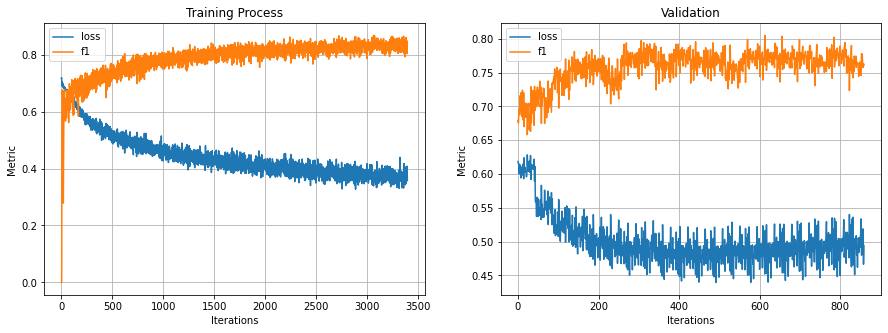

In [23]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

In [24]:
def plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval):

    mean_train_losses = []
    mean_train_f1s = []
    for epoch, losses in enumerate(losses_train):
        mean_train_losses.append(np.mean(losses))
        mean_train_f1s.append(np.mean(f1s_train[epoch]))

    mean_eval_losses = []
    mean_eval_f1s = []
    for epoch, losses in enumerate(losses_eval):
        mean_eval_losses.append(np.mean(losses))
        mean_eval_f1s.append(np.mean(f1s_eval[epoch]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title('BCE Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Metric')
    ax1.plot(mean_train_losses, label='train')
    ax1.plot(mean_eval_losses, label='test')
    ax1.legend()
    ax1.grid()

    ax2.set_title('F1-score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric')
    ax2.plot(mean_train_f1s, label='train')
    ax2.plot(mean_eval_f1s, label='test')
    ax2.legend()
    ax2.grid()

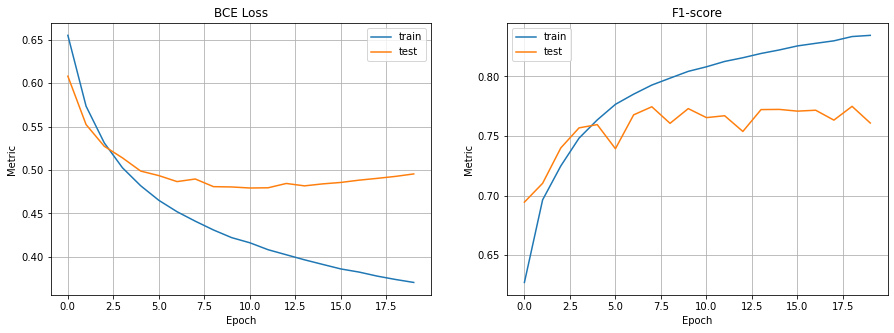

In [25]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

Тут тоже есть переобучение, как и в CNN-модели, хотя не такое сильное; плюс что-то странное происходит с f1 на тесте (его колбасит и он не растет уже после 7-8 эпохи).

### Улучшения
Сначала пройдемся по тем же пунктам, что были в первой части домашки. Мы уже знаем, как бороться с переобучением, поэтому добавим сразу и dropout, и нормализацию.

#### Dropout и нормализация

In [26]:
class WS_CNN1(nn.Module):

    def __init__(self, token_vocab_size, symbol_vocab_size,
                 token_embedding_dim, symbol_embedding_dim):

        super().__init__()

        # эмбеддинг-слой для слов
        self.token_embedding = nn.Embedding(token_vocab_size,
                                            token_embedding_dim)
        # нормализация
        self.token_batch_norm = nn.BatchNorm1d(100)
        self.token_hidden = nn.Linear(in_features=token_embedding_dim,
                                      out_features=100)

        # эмбеддинг-слой для символов
        self.symbol_embedding = nn.Embedding(symbol_vocab_size,
                                             symbol_embedding_dim)
        # биграммная свертка
        self.symbol_bigrams = nn.Conv1d(in_channels=symbol_embedding_dim,
                                        out_channels=100, kernel_size=2,
                                        padding='same')
        # триграммная свертка
        self.symbol_trigrams = nn.Conv1d(in_channels=symbol_embedding_dim,
                                         out_channels=80, kernel_size=3,
                                         padding='same')

        # нормализация
        self.batch_norm2 = nn.BatchNorm1d(100)
        self.batch_norm3 = nn.BatchNorm1d(80)

        self.hidden = nn.Linear(in_features=280, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.out = nn.Sigmoid()

    def forward(self, token_seq, symbol_seq):

        # вектор слов
        embedded_tokens = torch.mean(self.token_embedding(token_seq), dim=1)
        token_vector = self.token_batch_norm(self.dropout(
            self.relu(self.token_hidden(embedded_tokens))))

        # символьные эмбеддинги
        embedded_symbols = self.symbol_embedding(symbol_seq)
        embedded_symbols = embedded_symbols.transpose(1, 2)

        # сверточные слои
        feature_map_bigrams = self.batch_norm2(self.dropout(
            self.relu(self.symbol_bigrams(embedded_symbols))))
        feature_map_trigrams = self.batch_norm3(self.dropout(
            self.relu(self.symbol_trigrams(embedded_symbols))))

        # пулинг
        pooling1 = feature_map_bigrams.max(2)[0]
        pooling2 = feature_map_trigrams.max(2)[0]

        # конкатенация всего
        concat = torch.cat((pooling1, pooling2, token_vector), 1)

        # линейный слой + сигмоида
        logits = self.hidden(concat)
        logits = self.out(logits)

        return logits

In [27]:
ws1_model = WS_CNN1(len(token2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(ws1_model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

ws1_model = ws1_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [28]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(ws1_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.7665969834608191, Train f1: 0.5143266916275024
Train loss: 0.7347503146704506, Train f1: 0.5472237467765808
Train loss: 0.7167976025272819, Train f1: 0.5625947117805481
Train loss: 0.7025254443287849, Train f1: 0.5790148377418518
Train loss: 0.6906882587601156, Train f1: 0.5906407237052917

Validating...

Val loss: 0.6172688901424408, Val f1: 0.655799388885498
Val loss: 0.6165142320096493, Val f1: 0.6609549522399902
Val loss: 0.6158695394794146, Val f1: 0.6629340052604675
Val loss: 0.616861904039979, Val f1: 0.6590811014175415
Val loss: 0.6165311962366105, Val f1: 0.6620922088623047

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6272803001544055, Train f1: 0.6555386781692505
Train loss: 0.6228357123977998, Train f1: 0.6572198867797852
Train loss: 0.6180576822336983, Train f1: 0.6593685746192932
Train loss: 0.612610775319969, Train f1: 0.6633822321891785
Train loss: 0.608164571313297, Train f1: 0.6662380695343018

Validating...

Val loss: 0.5763995572924614, Val f1: 0.7143800258636475
Val loss: 0.5767451710999012, Val f1: 0.7141079902648926
Val loss: 0.5761342669526736, Val f1: 0.7153427600860596
Val loss: 0.5772212073206902, Val f1: 0.7139401435852051
Val loss: 0.5770353689789772, Val f1: 0.7157641649246216

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5764868452268488, Train f1: 0.6880106925964355
Train loss: 0.5743633964482475, Train f1: 0.6908189058303833
Train loss: 0.5715953298643524, Train f1: 0.692496120929718
Train loss: 0.568955722538864, Train f1: 0.6945794224739075
Train loss: 0.5665755429688621, Train f1: 0.6978282332420349

Validating...

Val loss: 0.5532588884234428, Val f1: 0.7276265621185303
Val loss: 0.5535396859049797, Val f1: 0.7291452288627625
Val loss: 0.552549920976162, Val f1: 0.7315254807472229
Val loss: 0.5532131437212229, Val f1: 0.7293362617492676
Val loss: 0.5531552746891976, Val f1: 0.7297995686531067

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5502351785407347, Train f1: 0.7095713019371033
Train loss: 0.5456905268570956, Train f1: 0.7145943641662598
Train loss: 0.5457493113536461, Train f1: 0.7137588262557983
Train loss: 0.5429673019577476, Train f1: 0.7164654731750488
Train loss: 0.5411163193338058, Train f1: 0.7180934548377991

Validating...

Val loss: 0.5355401039123535, Val f1: 0.7409893274307251
Val loss: 0.5364285781979561, Val f1: 0.7422398328781128
Val loss: 0.5355067625641823, Val f1: 0.7433052062988281
Val loss: 0.5358391888439655, Val f1: 0.7417436242103577
Val loss: 0.5359250664710998, Val f1: 0.7421262264251709

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5312049160985386, Train f1: 0.7287319898605347
Train loss: 0.5279975594843135, Train f1: 0.731553852558136
Train loss: 0.5253746401445538, Train f1: 0.7318218946456909
Train loss: 0.523419875651598, Train f1: 0.7327555418014526
Train loss: 0.5222185813328799, Train f1: 0.7329201102256775

Validating...

Val loss: 0.5287311039865017, Val f1: 0.7480936050415039
Val loss: 0.5291410218924284, Val f1: 0.7502071857452393
Val loss: 0.5284373598794142, Val f1: 0.7520261406898499
Val loss: 0.5282529061660171, Val f1: 0.7498031854629517
Val loss: 0.5287027128040791, Val f1: 0.7500174641609192

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.507931014194208, Train f1: 0.7444176077842712
Train loss: 0.508104615351733, Train f1: 0.7451333999633789
Train loss: 0.5061287657887328, Train f1: 0.7470954656600952
Train loss: 0.5051003536757301, Train f1: 0.7480491399765015
Train loss: 0.5037501999560524, Train f1: 0.7483600378036499

Validating...

Val loss: 0.519894078373909, Val f1: 0.753818929195404
Val loss: 0.5210160501301289, Val f1: 0.7553322315216064
Val loss: 0.5203466477493445, Val f1: 0.7561836242675781
Val loss: 0.5195516748353839, Val f1: 0.7541921138763428
Val loss: 0.5200165770947933, Val f1: 0.7545603513717651

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.49196230313357187, Train f1: 0.756601870059967
Train loss: 0.48940690782140284, Train f1: 0.7577865123748779
Train loss: 0.4895302472161312, Train f1: 0.7579656839370728
Train loss: 0.4898595871294246, Train f1: 0.756576657295227
Train loss: 0.4884333174018299, Train f1: 0.7580097913742065

Validating...

Val loss: 0.5097965896129608, Val f1: 0.7589210271835327
Val loss: 0.5111989323049784, Val f1: 0.7606289386749268
Val loss: 0.5107577554881573, Val f1: 0.7607472538948059
Val loss: 0.5095473481342196, Val f1: 0.7591837644577026
Val loss: 0.5103222995996475, Val f1: 0.7597557306289673

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4792623160516514, Train f1: 0.7669434547424316
Train loss: 0.4781570776420481, Train f1: 0.767365574836731
Train loss: 0.4783741282481773, Train f1: 0.7671613693237305
Train loss: 0.47676251675276193, Train f1: 0.76678866147995
Train loss: 0.4775044137940687, Train f1: 0.765924870967865

Validating...

Val loss: 0.5009265094995499, Val f1: 0.7626387476921082
Val loss: 0.5015427805483341, Val f1: 0.7643758058547974
Val loss: 0.5010043233633041, Val f1: 0.7656866908073425
Val loss: 0.5000357748940587, Val f1: 0.7642419338226318
Val loss: 0.5008798077702522, Val f1: 0.7642091512680054

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.46678782824207754, Train f1: 0.7732677459716797
Train loss: 0.46715756461900826, Train f1: 0.7727768421173096
Train loss: 0.46577692353257943, Train f1: 0.7742691040039062
Train loss: 0.4654892693985911, Train f1: 0.7749170660972595
Train loss: 0.46592893863425533, Train f1: 0.7739963531494141

Validating...

Val loss: 0.49261170625686646, Val f1: 0.7527666687965393
Val loss: 0.4926914758980274, Val f1: 0.7586709260940552
Val loss: 0.4919453834493955, Val f1: 0.7605693340301514
Val loss: 0.4905475964769721, Val f1: 0.7587499022483826
Val loss: 0.49153257682919504, Val f1: 0.75938481092453

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.45982499245335073, Train f1: 0.775973916053772
Train loss: 0.4558563039583318, Train f1: 0.7782063484191895
Train loss: 0.45486988740808826, Train f1: 0.7804809212684631
Train loss: 0.45466198158614773, Train f1: 0.7815038561820984
Train loss: 0.4549474446212544, Train f1: 0.7812398672103882

Validating...

Val loss: 0.49984994158148766, Val f1: 0.767020583152771
Val loss: 0.5011623222380877, Val f1: 0.7675167918205261
Val loss: 0.49998367577791214, Val f1: 0.7695586681365967
Val loss: 0.49812238197773695, Val f1: 0.7687518000602722
Val loss: 0.4994945913553238, Val f1: 0.767967939376831

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.44701187400256887, Train f1: 0.7856899499893188
Train loss: 0.4443382252665127, Train f1: 0.7878087162971497
Train loss: 0.4447786927807565, Train f1: 0.7880974411964417
Train loss: 0.44563772375969324, Train f1: 0.7875117063522339
Train loss: 0.44612026021761053, Train f1: 0.7876714468002319

Validating...

Val loss: 0.49043721705675125, Val f1: 0.75762939453125
Val loss: 0.4906163513660431, Val f1: 0.7605312466621399
Val loss: 0.48947931701938313, Val f1: 0.7619171142578125
Val loss: 0.4873667089268565, Val f1: 0.761036217212677
Val loss: 0.4884082220494747, Val f1: 0.7613643407821655

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.43929167091846466, Train f1: 0.791795551776886
Train loss: 0.4374769439592081, Train f1: 0.7923908829689026
Train loss: 0.43719513217608136, Train f1: 0.7927624583244324
Train loss: 0.43679402352255936, Train f1: 0.7937908172607422
Train loss: 0.4388163606910145, Train f1: 0.7930958271026611

Validating...

Val loss: 0.49733882397413254, Val f1: 0.770911455154419
Val loss: 0.4974462315440178, Val f1: 0.7710356712341309
Val loss: 0.49641822402675945, Val f1: 0.7723771929740906
Val loss: 0.4940522853285074, Val f1: 0.7715425491333008
Val loss: 0.4957699321210384, Val f1: 0.7708719372749329

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4238197058439255, Train f1: 0.803345263004303
Train loss: 0.42550886290914874, Train f1: 0.8013888001441956
Train loss: 0.4285832266597187, Train f1: 0.7989810705184937
Train loss: 0.4289771136553848, Train f1: 0.7988047003746033
Train loss: 0.4300250002566506, Train f1: 0.798228919506073

Validating...

Val loss: 0.49843355268239975, Val f1: 0.768845796585083
Val loss: 0.49875449016690254, Val f1: 0.7713969349861145
Val loss: 0.4976360524694125, Val f1: 0.7726303935050964
Val loss: 0.4951538164168596, Val f1: 0.7719374895095825
Val loss: 0.49684007912874223, Val f1: 0.7714332938194275

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4203943531302845, Train f1: 0.8015381693840027
Train loss: 0.423624171053662, Train f1: 0.8020780682563782
Train loss: 0.42264684158213, Train f1: 0.803022563457489
Train loss: 0.4239827043869916, Train f1: 0.8019719123840332
Train loss: 0.42454637762378244, Train f1: 0.8015224933624268

Validating...

Val loss: 0.48978326097130775, Val f1: 0.7599621415138245
Val loss: 0.48971280828118324, Val f1: 0.763775110244751
Val loss: 0.48831599081556004, Val f1: 0.7651020884513855
Val loss: 0.4861001381650567, Val f1: 0.7645342350006104
Val loss: 0.4875863313674927, Val f1: 0.7651122212409973

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.41707076482913075, Train f1: 0.8064038157463074
Train loss: 0.416782920851427, Train f1: 0.8071837425231934
Train loss: 0.41827163450858174, Train f1: 0.8062053918838501
Train loss: 0.4164498148157316, Train f1: 0.8068776726722717
Train loss: 0.41776207212139577, Train f1: 0.8067348003387451

Validating...

Val loss: 0.49260275065898895, Val f1: 0.7708745002746582
Val loss: 0.4937450531870127, Val f1: 0.7731223702430725
Val loss: 0.49234267075856525, Val f1: 0.7740138173103333
Val loss: 0.48983178194612265, Val f1: 0.7732516527175903
Val loss: 0.4914035826921463, Val f1: 0.7733715772628784

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.40968121588230133, Train f1: 0.8057221174240112
Train loss: 0.4098203975488158, Train f1: 0.8088522553443909
Train loss: 0.4115854720858967, Train f1: 0.8088929653167725
Train loss: 0.41146907298003926, Train f1: 0.8087455630302429
Train loss: 0.4116500070866416, Train f1: 0.8090531229972839

Validating...

Val loss: 0.5013317875564098, Val f1: 0.7674809694290161
Val loss: 0.5019882060587406, Val f1: 0.7716187238693237
Val loss: 0.5002416670322418, Val f1: 0.7730852961540222
Val loss: 0.4968584217131138, Val f1: 0.7727309465408325
Val loss: 0.49887800961732864, Val f1: 0.7725302577018738

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3985958905781017, Train f1: 0.8173558115959167
Train loss: 0.4035598714562023, Train f1: 0.8135617971420288
Train loss: 0.40394969489060195, Train f1: 0.8138601779937744
Train loss: 0.4049735599580933, Train f1: 0.8130573034286499
Train loss: 0.40527466482975905, Train f1: 0.8123167157173157

Validating...

Val loss: 0.49933622777462006, Val f1: 0.7657878994941711
Val loss: 0.499359929934144, Val f1: 0.7696244120597839
Val loss: 0.49692941332856816, Val f1: 0.7706528306007385
Val loss: 0.4937566826120019, Val f1: 0.7705491781234741
Val loss: 0.4957124337553978, Val f1: 0.7705075740814209

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.397581300314735, Train f1: 0.8169284462928772
Train loss: 0.39785251065212135, Train f1: 0.8164729475975037
Train loss: 0.3982627236959981, Train f1: 0.8154693841934204
Train loss: 0.399232838083716, Train f1: 0.8157103061676025
Train loss: 0.39997579823522006, Train f1: 0.8154627084732056

Validating...

Val loss: 0.5032563284039497, Val f1: 0.763898491859436
Val loss: 0.5033599901944399, Val f1: 0.7653114795684814
Val loss: 0.5008449542025725, Val f1: 0.7664821743965149
Val loss: 0.49742033146321774, Val f1: 0.7670096158981323
Val loss: 0.4995731145143509, Val f1: 0.7669504880905151

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3912736861144795, Train f1: 0.8228715658187866
Train loss: 0.3925871025113499, Train f1: 0.8212199211120605
Train loss: 0.39221497201452066, Train f1: 0.8212084770202637
Train loss: 0.39369772856726365, Train f1: 0.8196864128112793
Train loss: 0.3957623376565821, Train f1: 0.8179457783699036

Validating...

Val loss: 0.5001505799591541, Val f1: 0.7622319459915161
Val loss: 0.5016828123480082, Val f1: 0.7639478445053101
Val loss: 0.49885595341523487, Val f1: 0.7645756602287292
Val loss: 0.49549491237848997, Val f1: 0.765427827835083
Val loss: 0.4973489411175251, Val f1: 0.7653534412384033

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.3882117692162009, Train f1: 0.8206436634063721
Train loss: 0.3898000980124754, Train f1: 0.8213966488838196
Train loss: 0.38948802562320933, Train f1: 0.8206036686897278
Train loss: 0.3915231631082647, Train f1: 0.820398211479187
Train loss: 0.39222401923993055, Train f1: 0.8196244239807129

Validating...

Val loss: 0.5028754621744156, Val f1: 0.7714534401893616
Val loss: 0.504721075296402, Val f1: 0.7741778492927551
Val loss: 0.5021670137842497, Val f1: 0.7750346660614014
Val loss: 0.49847041442990303, Val f1: 0.7750925421714783
Val loss: 0.5007155507802963, Val f1: 0.7750431895256042


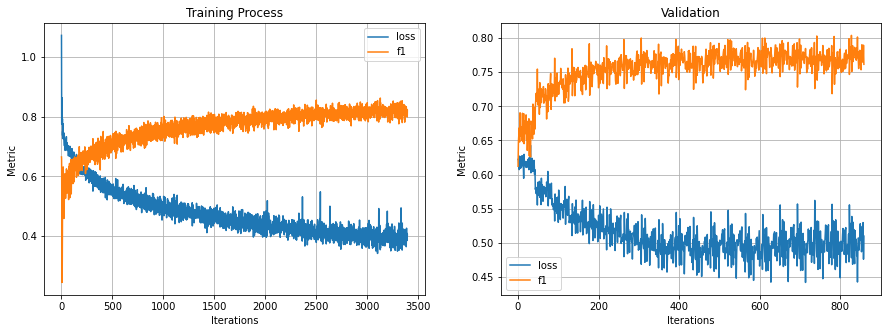

In [29]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

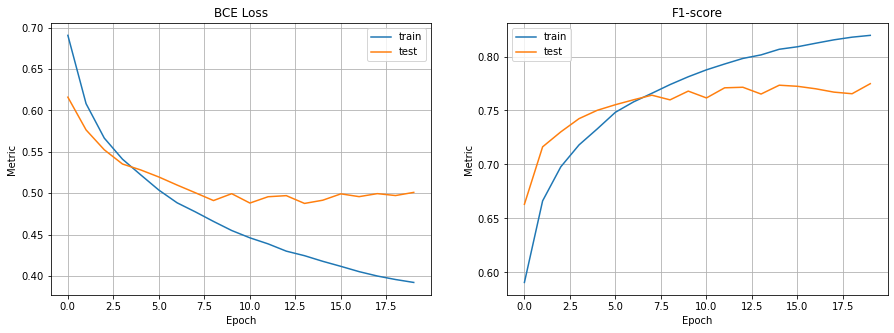

In [30]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

Стало как будто бы ровнее, но не особо лучше. Посмотрим на метрики.

In [31]:
# тут все еще нет эмбеддингов, это ошибка
print(
    'WS-CNN с FastText-эмбеддингами до улучшений: loss = {}, f1 = {}'.format(
        initial_ws_loss, initial_ws_f1))

initial_ws1_loss = np.mean(losses_eval[-1])
initial_ws1_f1 = np.mean(f1s_eval[-1])
print(
    'WS-CNN с dropout\'ом и нормализацией: loss = {}, f1 = {}'.format(
        initial_ws1_loss, initial_ws1_f1))

WS-CNN с FastText-эмбеддингами до улучшений: loss = 0.4954905967379725, f1 = 0.7609487771987915
WS-CNN с dropout'ом и нормализацией: loss = 0.5010097816933033, f1 = 0.7748349905014038


Да, ничего хорошего: f1 чуть выросла, но и лосс тоже. Пока сохраняем дропаут и нормализацию и докручиваем параметры.

#### Weight decay
Это опять идея из Гугла, потому что я не с ИАДа. Источник: [Deep learning basics — weight decay](https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9).

In [32]:
ws2_model = WS_CNN1(len(token2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(ws2_model.parameters(),
                       lr=0.0005, weight_decay=1e-4)
criterion = nn.BCELoss()

ws2_model = ws2_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [33]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(ws2_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.7150630372412065, Train f1: 0.5622187852859497
Train loss: 0.693695455789566, Train f1: 0.583472728729248
Train loss: 0.6799264322308933, Train f1: 0.5967156291007996
Train loss: 0.6699401582865154, Train f1: 0.6082671880722046
Train loss: 0.6613554130582249, Train f1: 0.6164421439170837

Validating...

Val loss: 0.6207615435123444, Val f1: 0.7066814303398132
Val loss: 0.6214303746819496, Val f1: 0.7052392959594727
Val loss: 0.6213436275720596, Val f1: 0.7049048542976379
Val loss: 0.6223343461751938, Val f1: 0.703778862953186
Val loss: 0.6223722144961357, Val f1: 0.7042948007583618

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6176565780359156, Train f1: 0.6623321175575256
Train loss: 0.6136321653338039, Train f1: 0.6624326109886169
Train loss: 0.6111029293022904, Train f1: 0.6631174087524414
Train loss: 0.6081099711796817, Train f1: 0.6640626192092896
Train loss: 0.6042361000004937, Train f1: 0.6667980551719666

Validating...

Val loss: 0.5877851918339729, Val f1: 0.7148642539978027
Val loss: 0.5890309177339077, Val f1: 0.7137020826339722
Val loss: 0.5890229592720667, Val f1: 0.7139604687690735
Val loss: 0.5900816190987825, Val f1: 0.7126916646957397
Val loss: 0.5901374444365501, Val f1: 0.7132800221443176

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5867594655822305, Train f1: 0.6822721362113953
Train loss: 0.5840383952154833, Train f1: 0.6810813546180725
Train loss: 0.5826060228488025, Train f1: 0.6826109290122986
Train loss: 0.5831176318666514, Train f1: 0.6786911487579346
Train loss: 0.581666944658055, Train f1: 0.6803139448165894

Validating...

Val loss: 0.5772219970822334, Val f1: 0.7194405794143677
Val loss: 0.5785706788301468, Val f1: 0.7173839807510376
Val loss: 0.5787339434027672, Val f1: 0.7204573154449463
Val loss: 0.5795952063053846, Val f1: 0.718840479850769
Val loss: 0.5795483127236366, Val f1: 0.719745934009552

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5730529182097491, Train f1: 0.6837725639343262
Train loss: 0.5720621277304256, Train f1: 0.6849287748336792
Train loss: 0.5695022344589233, Train f1: 0.6880099177360535
Train loss: 0.5689705351696295, Train f1: 0.6883559226989746
Train loss: 0.5682471398045035, Train f1: 0.6895202994346619

Validating...

Val loss: 0.5682597011327744, Val f1: 0.7210538983345032
Val loss: 0.5694768354296684, Val f1: 0.7195733785629272
Val loss: 0.5694381222128868, Val f1: 0.7234446406364441
Val loss: 0.5699621085077524, Val f1: 0.721764326095581
Val loss: 0.5698620229959488, Val f1: 0.7227651476860046

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5655297286370221, Train f1: 0.6901281476020813
Train loss: 0.5636186468250611, Train f1: 0.6937760710716248
Train loss: 0.5624373192880668, Train f1: 0.6948455572128296
Train loss: 0.5623161332572207, Train f1: 0.6954048275947571
Train loss: 0.5607880971010993, Train f1: 0.696683406829834

Validating...

Val loss: 0.5819399133324623, Val f1: 0.7280367612838745
Val loss: 0.5837095491588116, Val f1: 0.7267047166824341
Val loss: 0.5836014424761137, Val f1: 0.7278960347175598
Val loss: 0.5840498004108667, Val f1: 0.7280741930007935
Val loss: 0.5839852914214134, Val f1: 0.7288466095924377

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5574127996669096, Train f1: 0.7002761363983154
Train loss: 0.5565584678860271, Train f1: 0.699073314666748
Train loss: 0.5539010511893853, Train f1: 0.7016935348510742
Train loss: 0.5550733191125533, Train f1: 0.7010429501533508
Train loss: 0.5548028041334713, Train f1: 0.700965166091919

Validating...

Val loss: 0.5699677914381027, Val f1: 0.7363832592964172
Val loss: 0.5718328356742859, Val f1: 0.7340667843818665
Val loss: 0.5718046327431997, Val f1: 0.7338578104972839
Val loss: 0.5720009971410036, Val f1: 0.7338969707489014
Val loss: 0.5720343843102456, Val f1: 0.7344112396240234

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5503265279180863, Train f1: 0.7063730955123901
Train loss: 0.5507834132979897, Train f1: 0.704119086265564
Train loss: 0.5510539015134176, Train f1: 0.7036513686180115
Train loss: 0.5513308311209959, Train f1: 0.7028710842132568
Train loss: 0.5516432649949018, Train f1: 0.7024762034416199

Validating...

Val loss: 0.5553860887885094, Val f1: 0.7374428510665894
Val loss: 0.5570840612053871, Val f1: 0.7348711490631104
Val loss: 0.5573526471853256, Val f1: 0.7366588115692139
Val loss: 0.5577823054045439, Val f1: 0.7352042198181152
Val loss: 0.557703149318695, Val f1: 0.7353310585021973

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5528279087122749, Train f1: 0.701240062713623
Train loss: 0.5501784147585139, Train f1: 0.7057154774665833
Train loss: 0.5494755155899945, Train f1: 0.7039139866828918
Train loss: 0.5473350071731735, Train f1: 0.7056497931480408
Train loss: 0.5469391381039339, Train f1: 0.7059891223907471

Validating...

Val loss: 0.5507948994636536, Val f1: 0.7374749183654785
Val loss: 0.5530533976852894, Val f1: 0.7339999079704285
Val loss: 0.5533415228128433, Val f1: 0.7359108924865723
Val loss: 0.5533957742154598, Val f1: 0.7342875003814697
Val loss: 0.5533021375536918, Val f1: 0.7350689172744751

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5440588470767526, Train f1: 0.7121885418891907
Train loss: 0.5423691509401097, Train f1: 0.712766706943512
Train loss: 0.541163900903627, Train f1: 0.7124680280685425
Train loss: 0.5421196437057327, Train f1: 0.7128404974937439
Train loss: 0.542274174970739, Train f1: 0.7123123407363892

Validating...

Val loss: 0.5505213588476181, Val f1: 0.7382389307022095
Val loss: 0.5529565326869488, Val f1: 0.7358466386795044
Val loss: 0.5530419697364172, Val f1: 0.7375007271766663
Val loss: 0.5530887991189957, Val f1: 0.7366174459457397
Val loss: 0.5531230285763741, Val f1: 0.7370337247848511

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5393931585199693, Train f1: 0.7189303040504456
Train loss: 0.5397416458410376, Train f1: 0.7153692841529846
Train loss: 0.5408882691579706, Train f1: 0.7143086194992065
Train loss: 0.5405841522357043, Train f1: 0.7133756279945374
Train loss: 0.5399316970039817, Train f1: 0.7139525413513184

Validating...

Val loss: 0.5501830205321312, Val f1: 0.7467096447944641
Val loss: 0.5527973510324955, Val f1: 0.7426989078521729
Val loss: 0.5531250064571699, Val f1: 0.7430750727653503
Val loss: 0.5533823184669018, Val f1: 0.7416627407073975
Val loss: 0.5535011321306229, Val f1: 0.7421175837516785

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5351090948371326, Train f1: 0.7190979719161987
Train loss: 0.5375394930734354, Train f1: 0.714429497718811
Train loss: 0.5376834656093635, Train f1: 0.7163666486740112
Train loss: 0.5368328223771909, Train f1: 0.7169803977012634
Train loss: 0.5363197072463877, Train f1: 0.7164881229400635

Validating...

Val loss: 0.5349418818950653, Val f1: 0.7390301823616028
Val loss: 0.5380870699882507, Val f1: 0.7365983128547668
Val loss: 0.5386110345522562, Val f1: 0.7375999093055725
Val loss: 0.538649894297123, Val f1: 0.7363404035568237
Val loss: 0.539086976647377, Val f1: 0.7359729409217834

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5298182675067116, Train f1: 0.7195760607719421
Train loss: 0.5308897490887081, Train f1: 0.7203695774078369
Train loss: 0.5308426110183492, Train f1: 0.7209235429763794
Train loss: 0.5314796965788392, Train f1: 0.7204211950302124
Train loss: 0.5323853587403017, Train f1: 0.7205269932746887

Validating...

Val loss: 0.5412878170609474, Val f1: 0.749143123626709
Val loss: 0.5440964587032795, Val f1: 0.7468667030334473
Val loss: 0.5445568213860194, Val f1: 0.7472257614135742
Val loss: 0.5445171352475882, Val f1: 0.7456120252609253
Val loss: 0.5447260990738869, Val f1: 0.746226966381073

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5277803312329685, Train f1: 0.7225524187088013
Train loss: 0.5270325261003831, Train f1: 0.724507749080658
Train loss: 0.5279839786828733, Train f1: 0.7245408892631531
Train loss: 0.5279339006280198, Train f1: 0.7243695855140686
Train loss: 0.5281184522544636, Train f1: 0.724294126033783

Validating...

Val loss: 0.52687768638134, Val f1: 0.7407026290893555
Val loss: 0.5294827334582806, Val f1: 0.7384331226348877
Val loss: 0.5299015368024508, Val f1: 0.7398748397827148
Val loss: 0.5299176909029484, Val f1: 0.7381807565689087
Val loss: 0.5302586510777474, Val f1: 0.7377799153327942

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5277605232070474, Train f1: 0.7251839637756348
Train loss: 0.5267410006593255, Train f1: 0.7278486490249634
Train loss: 0.5246845951267317, Train f1: 0.7279233932495117
Train loss: 0.52509878860677, Train f1: 0.7273896336555481
Train loss: 0.524839880010661, Train f1: 0.7273179888725281

Validating...

Val loss: 0.5249796658754349, Val f1: 0.7491384744644165
Val loss: 0.5278902687132359, Val f1: 0.7465680837631226
Val loss: 0.5281220078468323, Val f1: 0.7475605010986328
Val loss: 0.5280790328979492, Val f1: 0.7456889748573303
Val loss: 0.5284457102417945, Val f1: 0.7455161809921265

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5186604015967425, Train f1: 0.7324743866920471
Train loss: 0.5200216489679673, Train f1: 0.7316436767578125
Train loss: 0.5227568435902689, Train f1: 0.7301563024520874
Train loss: 0.5219538579968845, Train f1: 0.7296541929244995
Train loss: 0.5218880730516771, Train f1: 0.7300871014595032

Validating...

Val loss: 0.5288632810115814, Val f1: 0.7470142841339111
Val loss: 0.5313959382474422, Val f1: 0.7454842329025269
Val loss: 0.5317995920777321, Val f1: 0.7462881207466125
Val loss: 0.5318278390914202, Val f1: 0.7449005842208862
Val loss: 0.5319373503327369, Val f1: 0.7450439929962158

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5222383544725531, Train f1: 0.7283850908279419
Train loss: 0.5203609633095124, Train f1: 0.7311303019523621
Train loss: 0.5191568705965491, Train f1: 0.7305586338043213
Train loss: 0.5189681075075093, Train f1: 0.7309812307357788
Train loss: 0.5192025363445282, Train f1: 0.7304543852806091

Validating...

Val loss: 0.5336696431040764, Val f1: 0.7518710494041443
Val loss: 0.5365290194749832, Val f1: 0.7511894702911377
Val loss: 0.536519872645537, Val f1: 0.7526834607124329
Val loss: 0.5364465229213238, Val f1: 0.7509344220161438
Val loss: 0.536867943406105, Val f1: 0.7511575818061829

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5117910732241238, Train f1: 0.7371918559074402
Train loss: 0.5128433879683999, Train f1: 0.7351150512695312
Train loss: 0.5130282783625173, Train f1: 0.7339039444923401
Train loss: 0.5132510887787622, Train f1: 0.7343937754631042
Train loss: 0.5130025989869061, Train f1: 0.7347915172576904

Validating...

Val loss: 0.5245452672243118, Val f1: 0.754801332950592
Val loss: 0.527490645647049, Val f1: 0.7535394430160522
Val loss: 0.5274514307578405, Val f1: 0.7558813095092773
Val loss: 0.5270394012331963, Val f1: 0.7545003890991211
Val loss: 0.5275140911340713, Val f1: 0.7543883323669434

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.505914453197928, Train f1: 0.7445027232170105
Train loss: 0.5069755745284698, Train f1: 0.7405804991722107
Train loss: 0.5084392828684227, Train f1: 0.740485668182373
Train loss: 0.5081757835167295, Train f1: 0.7413673400878906
Train loss: 0.5085154428201564, Train f1: 0.740857720375061

Validating...

Val loss: 0.5168770402669907, Val f1: 0.7559442520141602
Val loss: 0.520511407405138, Val f1: 0.7543343305587769
Val loss: 0.5202577039599419, Val f1: 0.755622386932373
Val loss: 0.5197937563061714, Val f1: 0.7547881603240967
Val loss: 0.5203440666198731, Val f1: 0.7552109956741333

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4996921744416742, Train f1: 0.7484060525894165
Train loss: 0.5029787346720695, Train f1: 0.7453259229660034
Train loss: 0.5039041121216381, Train f1: 0.7439958453178406
Train loss: 0.5056816652855453, Train f1: 0.7429388761520386
Train loss: 0.5049590003841063, Train f1: 0.7433843016624451

Validating...

Val loss: 0.5005970522761345, Val f1: 0.7508167028427124
Val loss: 0.503533661365509, Val f1: 0.7464909553527832
Val loss: 0.5036866987744967, Val f1: 0.7459703087806702
Val loss: 0.5031890701502562, Val f1: 0.7450176477432251
Val loss: 0.503971466422081, Val f1: 0.744255781173706

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4980514733230366, Train f1: 0.7471786141395569
Train loss: 0.4998034317703808, Train f1: 0.7462842464447021
Train loss: 0.49911512755880166, Train f1: 0.7457483410835266
Train loss: 0.49816011922324405, Train f1: 0.7464674711227417
Train loss: 0.4989693631144131, Train f1: 0.7466182708740234

Validating...

Val loss: 0.5008046515285969, Val f1: 0.7508338689804077
Val loss: 0.5039468295872211, Val f1: 0.747672438621521
Val loss: 0.5041621352235476, Val f1: 0.7485925555229187
Val loss: 0.5037475032731891, Val f1: 0.7481077909469604
Val loss: 0.5043555535376072, Val f1: 0.7479767203330994


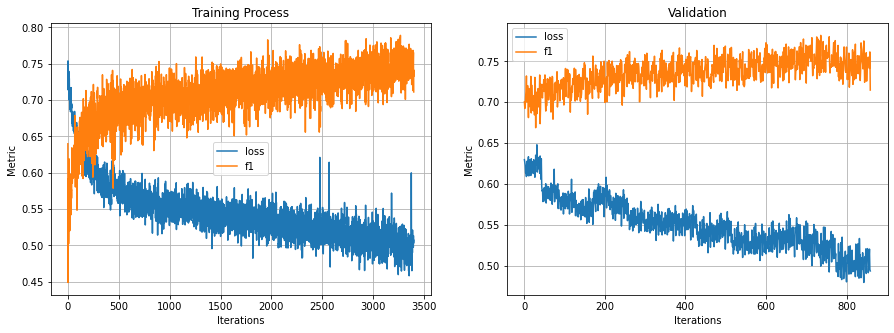

In [34]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

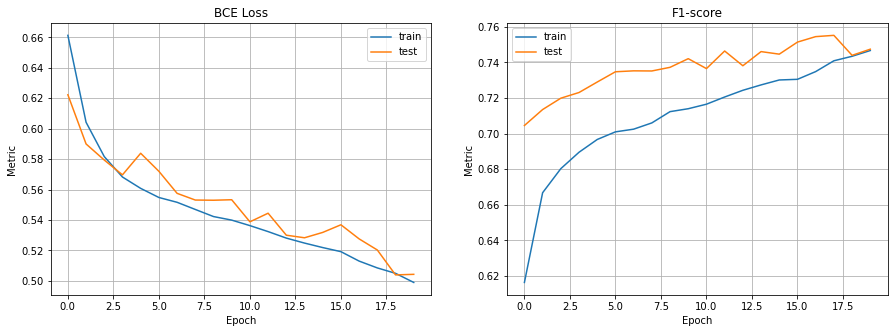

In [35]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

In [36]:
print(
    'WS-CNN с dropout\'ом и нормализацией: loss = {}, f1 = {}'.format(
        initial_ws1_loss, initial_ws1_f1))

initial_ws2_loss = np.mean(losses_eval[-1])
initial_ws2_f1 = np.mean(f1s_eval[-1])
print(
    'WS-CNN с dropout, нормализацией и weight decay: \
loss = {}, f1 = {}'.format(initial_ws2_loss, initial_ws2_f1))

WS-CNN с dropout'ом и нормализацией: loss = 0.5010097816933033, f1 = 0.7748349905014038
WS-CNN с dropout, нормализацией и weight decay: loss = 0.5043005361113437, f1 = 0.7473658919334412


Переобучение ушло, лосс примерно такой же, а вот качество немного упало :( Но видно, что это происходит уже в конце обучения. Что, если попробовать чуть бОльший learning rate?

#### Learning rate

In [37]:
ws3_model = WS_CNN1(len(token2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(ws3_model.parameters(),
                       lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss()

ws3_model = ws3_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [38]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(ws3_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.8349614721887252, Train f1: 0.4792218506336212
Train loss: 0.7521937340497971, Train f1: 0.5444157719612122
Train loss: 0.7173122781164506, Train f1: 0.5741646885871887
Train loss: 0.6951998388942551, Train f1: 0.5929620265960693
Train loss: 0.6793169947231517, Train f1: 0.6069490313529968

Validating...

Val loss: 0.5973551496863365, Val f1: 0.6468574404716492
Val loss: 0.5977360345423222, Val f1: 0.6506881713867188
Val loss: 0.5992730781435966, Val f1: 0.6490634679794312
Val loss: 0.5996351651847363, Val f1: 0.6477975845336914
Val loss: 0.5993071690201759, Val f1: 0.6515606045722961

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6034647331518286, Train f1: 0.6693984270095825
Train loss: 0.5996008629308027, Train f1: 0.6701051592826843
Train loss: 0.597140930446924, Train f1: 0.6715107560157776
Train loss: 0.5935396595912821, Train f1: 0.6750074028968811
Train loss: 0.5909606989692239, Train f1: 0.6775535941123962

Validating...

Val loss: 0.5671826004981995, Val f1: 0.7179530262947083
Val loss: 0.5689464025199413, Val f1: 0.7160788774490356
Val loss: 0.5707522357503573, Val f1: 0.7121842503547668
Val loss: 0.5712374877184629, Val f1: 0.7092556357383728
Val loss: 0.5711107566952706, Val f1: 0.7107044458389282

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.574972952113432, Train f1: 0.6836234927177429
Train loss: 0.5748422049424228, Train f1: 0.6846586465835571
Train loss: 0.5723135699244106, Train f1: 0.6890214681625366
Train loss: 0.569794228848289, Train f1: 0.6915097236633301
Train loss: 0.5679480450994828, Train f1: 0.6932328939437866

Validating...

Val loss: 0.552093856036663, Val f1: 0.7039605379104614
Val loss: 0.5534736476838589, Val f1: 0.7022947072982788
Val loss: 0.5556163489818573, Val f1: 0.6987807750701904
Val loss: 0.5563797764480114, Val f1: 0.6954178214073181
Val loss: 0.5563947543501854, Val f1: 0.6968512535095215

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5618862807750702, Train f1: 0.694168210029602
Train loss: 0.5593042610322728, Train f1: 0.6947901248931885
Train loss: 0.5568015505285824, Train f1: 0.6988179087638855
Train loss: 0.5561419024186975, Train f1: 0.6994607448577881
Train loss: 0.5555819904102999, Train f1: 0.7004307508468628

Validating...

Val loss: 0.5426635146141052, Val f1: 0.7199548482894897
Val loss: 0.5436622686684132, Val f1: 0.7175750136375427
Val loss: 0.5457511643568674, Val f1: 0.7142892479896545
Val loss: 0.5461841598153114, Val f1: 0.7113603949546814
Val loss: 0.5462612301111222, Val f1: 0.7124621868133545

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5508029022637535, Train f1: 0.7018024325370789
Train loss: 0.5479118525981903, Train f1: 0.7031890749931335
Train loss: 0.548018172675488, Train f1: 0.7059577703475952
Train loss: 0.5479937445591477, Train f1: 0.7056556344032288
Train loss: 0.5481036035453573, Train f1: 0.7060191631317139

Validating...

Val loss: 0.5651604384183884, Val f1: 0.7410539388656616
Val loss: 0.5686169303953648, Val f1: 0.7396001219749451
Val loss: 0.570814403394858, Val f1: 0.7387940287590027
Val loss: 0.5712715778499842, Val f1: 0.7385915517807007
Val loss: 0.5719834059476853, Val f1: 0.7385832667350769

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5391359732431524, Train f1: 0.7169632911682129
Train loss: 0.5390610826366088, Train f1: 0.7165106534957886
Train loss: 0.5420711794320274, Train f1: 0.7121425867080688
Train loss: 0.5428091870511279, Train f1: 0.7105950117111206
Train loss: 0.5429358678705553, Train f1: 0.7099894285202026

Validating...

Val loss: 0.5390731915831566, Val f1: 0.7472687363624573
Val loss: 0.5417076274752617, Val f1: 0.7467635273933411
Val loss: 0.5435826381047567, Val f1: 0.7448059916496277
Val loss: 0.5437301062047482, Val f1: 0.7418871521949768
Val loss: 0.5444612130522728, Val f1: 0.7422074675559998

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.537132557700662, Train f1: 0.7166518568992615
Train loss: 0.538276930065716, Train f1: 0.7144026160240173
Train loss: 0.5377333976474463, Train f1: 0.7154000997543335
Train loss: 0.5367458230432343, Train f1: 0.7170891761779785
Train loss: 0.5364917351919062, Train f1: 0.7171814441680908

Validating...

Val loss: 0.5273738950490952, Val f1: 0.7374277114868164
Val loss: 0.5299391373991966, Val f1: 0.7345016598701477
Val loss: 0.5317520573735237, Val f1: 0.7305790781974792
Val loss: 0.531867440789938, Val f1: 0.7292360067367554
Val loss: 0.5324127122759819, Val f1: 0.7294835448265076

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5333983512485728, Train f1: 0.7165999412536621
Train loss: 0.532540013684946, Train f1: 0.7189787030220032
Train loss: 0.5310536035720039, Train f1: 0.7208706736564636
Train loss: 0.5306880300974145, Train f1: 0.7213001251220703
Train loss: 0.5301238117849125, Train f1: 0.7217637300491333

Validating...

Val loss: 0.5378331169486046, Val f1: 0.7409526705741882
Val loss: 0.5412467643618584, Val f1: 0.7410888075828552
Val loss: 0.5433781296014786, Val f1: 0.7412824630737305
Val loss: 0.5436118710786104, Val f1: 0.7400637865066528
Val loss: 0.5448764324188232, Val f1: 0.7401363849639893

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5234882314415539, Train f1: 0.7244898080825806
Train loss: 0.522813605473322, Train f1: 0.7271789312362671
Train loss: 0.5236497351936266, Train f1: 0.7285284996032715
Train loss: 0.5235862582921982, Train f1: 0.7286025881767273
Train loss: 0.522024334528867, Train f1: 0.7298358082771301

Validating...

Val loss: 0.5351175293326378, Val f1: 0.7519130706787109
Val loss: 0.5385277196764946, Val f1: 0.7521512508392334
Val loss: 0.5404729892810186, Val f1: 0.7506027221679688
Val loss: 0.5405574608594179, Val f1: 0.7495123744010925
Val loss: 0.5414714381098747, Val f1: 0.7499052286148071

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5152493469855365, Train f1: 0.7346500754356384
Train loss: 0.5163186451091486, Train f1: 0.7355007529258728
Train loss: 0.5172566879613727, Train f1: 0.7329473495483398
Train loss: 0.5176325240994201, Train f1: 0.7321646809577942
Train loss: 0.5175943635842379, Train f1: 0.7314423322677612

Validating...

Val loss: 0.5173606276512146, Val f1: 0.7537676692008972
Val loss: 0.5205716043710709, Val f1: 0.7553171515464783
Val loss: 0.5220887164274851, Val f1: 0.7540538311004639
Val loss: 0.5223093219101429, Val f1: 0.7531591057777405
Val loss: 0.5231165364384651, Val f1: 0.7523484230041504

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5170566562344047, Train f1: 0.7304638624191284
Train loss: 0.514209996251499, Train f1: 0.7318532466888428
Train loss: 0.5146316520723642, Train f1: 0.7329667806625366
Train loss: 0.5134318034876796, Train f1: 0.733202338218689
Train loss: 0.5136833508225048, Train f1: 0.7335249781608582

Validating...

Val loss: 0.5038888454437256, Val f1: 0.7526288628578186
Val loss: 0.5072235725820065, Val f1: 0.7528297901153564
Val loss: 0.5091093753774961, Val f1: 0.7529544234275818
Val loss: 0.508898408152163, Val f1: 0.7513387203216553
Val loss: 0.5105190649628639, Val f1: 0.7513490915298462

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5061617239433176, Train f1: 0.7361086010932922
Train loss: 0.5072724648258266, Train f1: 0.7378732562065125
Train loss: 0.5071684008135515, Train f1: 0.7382627725601196
Train loss: 0.5075428385068389, Train f1: 0.7393136024475098
Train loss: 0.506881671442705, Train f1: 0.7393327951431274

Validating...

Val loss: 0.524684488773346, Val f1: 0.7636470198631287
Val loss: 0.5293303467333317, Val f1: 0.764129638671875
Val loss: 0.5315327420830727, Val f1: 0.7632248997688293
Val loss: 0.5316504277288914, Val f1: 0.7623694539070129
Val loss: 0.5335693404078483, Val f1: 0.7618090510368347

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5015092351857353, Train f1: 0.7457275390625
Train loss: 0.5004392349544693, Train f1: 0.7452875375747681
Train loss: 0.5005228750261606, Train f1: 0.7455567121505737
Train loss: 0.5015135451274759, Train f1: 0.7461115717887878
Train loss: 0.5021120441310546, Train f1: 0.7457615733146667

Validating...

Val loss: 0.519658587872982, Val f1: 0.763036847114563
Val loss: 0.5223726592957973, Val f1: 0.7657424807548523
Val loss: 0.5239647055665652, Val f1: 0.7640944123268127
Val loss: 0.5236225323751569, Val f1: 0.7631715536117554
Val loss: 0.5250706918537617, Val f1: 0.7631922960281372

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.49323474659639244, Train f1: 0.7481206059455872
Train loss: 0.49551568618592096, Train f1: 0.7489545345306396
Train loss: 0.4963349980466506, Train f1: 0.7495130896568298
Train loss: 0.49694030534695177, Train f1: 0.7481837272644043
Train loss: 0.4976383610683329, Train f1: 0.7474461197853088

Validating...

Val loss: 0.49900488182902336, Val f1: 0.7324403524398804
Val loss: 0.5000771824270487, Val f1: 0.7309168577194214
Val loss: 0.5017274903754393, Val f1: 0.7300682067871094
Val loss: 0.5009620487689972, Val f1: 0.7298554182052612
Val loss: 0.5020468309521675, Val f1: 0.7296673059463501

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4998934496851528, Train f1: 0.7461233139038086
Train loss: 0.4969518662375562, Train f1: 0.7477436065673828
Train loss: 0.4994993303336349, Train f1: 0.74546879529953
Train loss: 0.4997955882812248, Train f1: 0.745335578918457
Train loss: 0.5003270303501802, Train f1: 0.7446886301040649

Validating...

Val loss: 0.4876878038048744, Val f1: 0.7629036903381348
Val loss: 0.49055812507867813, Val f1: 0.7647289037704468
Val loss: 0.49221574142575264, Val f1: 0.7627263069152832
Val loss: 0.4915081271901727, Val f1: 0.7618613243103027
Val loss: 0.49249059781432153, Val f1: 0.7609594464302063

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.48367005761931925, Train f1: 0.7614060044288635
Train loss: 0.4895268937244135, Train f1: 0.755698561668396
Train loss: 0.4926203968478184, Train f1: 0.7517715096473694
Train loss: 0.4947523312533603, Train f1: 0.7486937046051025
Train loss: 0.496200729117674, Train f1: 0.7480958104133606

Validating...

Val loss: 0.5063726380467415, Val f1: 0.7706480622291565
Val loss: 0.5087980721145868, Val f1: 0.772062361240387
Val loss: 0.5093177234133085, Val f1: 0.7710331082344055
Val loss: 0.5085530504584312, Val f1: 0.7708719968795776
Val loss: 0.5094173863530159, Val f1: 0.7711479663848877

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.49078299718744617, Train f1: 0.7544981241226196
Train loss: 0.48889592333751564, Train f1: 0.7547092437744141
Train loss: 0.4908066006267772, Train f1: 0.7541084289550781
Train loss: 0.494763193104197, Train f1: 0.7504822015762329
Train loss: 0.4954533992444768, Train f1: 0.7488443851470947

Validating...

Val loss: 0.5097105242311954, Val f1: 0.7697638273239136
Val loss: 0.5115752331912518, Val f1: 0.7709912657737732
Val loss: 0.5121433883905411, Val f1: 0.7709586024284363
Val loss: 0.5114894341677427, Val f1: 0.7705768346786499
Val loss: 0.5118396729230881, Val f1: 0.7708519101142883

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.47587598772609935, Train f1: 0.7681921720504761
Train loss: 0.4796955752022126, Train f1: 0.7630336880683899
Train loss: 0.48440230184910343, Train f1: 0.7589995265007019
Train loss: 0.48649032917969365, Train f1: 0.7562080025672913
Train loss: 0.48810782748110154, Train f1: 0.7552358508110046

Validating...

Val loss: 0.507140040397644, Val f1: 0.6894922256469727
Val loss: 0.5082727763801813, Val f1: 0.686843752861023
Val loss: 0.5086914499600729, Val f1: 0.686093807220459
Val loss: 0.5083442833274603, Val f1: 0.6843299865722656
Val loss: 0.5083976842463016, Val f1: 0.6851743459701538

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4810332822449067, Train f1: 0.7594242691993713
Train loss: 0.4818694372387493, Train f1: 0.7605114579200745
Train loss: 0.48311348347102895, Train f1: 0.7597436904907227
Train loss: 0.48438671669539285, Train f1: 0.7582593560218811
Train loss: 0.4850338232867858, Train f1: 0.7574601769447327

Validating...

Val loss: 0.4840332344174385, Val f1: 0.7377606630325317
Val loss: 0.48577666096389294, Val f1: 0.7374016642570496
Val loss: 0.486042865862449, Val f1: 0.7360587120056152
Val loss: 0.48472556564956903, Val f1: 0.7361584901809692
Val loss: 0.4851009972393513, Val f1: 0.7359509468078613

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.48093318763901205, Train f1: 0.7582411766052246
Train loss: 0.48200815214830284, Train f1: 0.758287250995636
Train loss: 0.4817185109736873, Train f1: 0.7581531405448914
Train loss: 0.4823276755564353, Train f1: 0.7582281827926636
Train loss: 0.48451598093790166, Train f1: 0.7575299143791199

Validating...

Val loss: 0.4925616607069969, Val f1: 0.7708010673522949
Val loss: 0.49298739433288574, Val f1: 0.7721529006958008
Val loss: 0.49268237004677456, Val f1: 0.7724993824958801
Val loss: 0.49215903878211975, Val f1: 0.7729243040084839
Val loss: 0.49236706644296646, Val f1: 0.7733892202377319


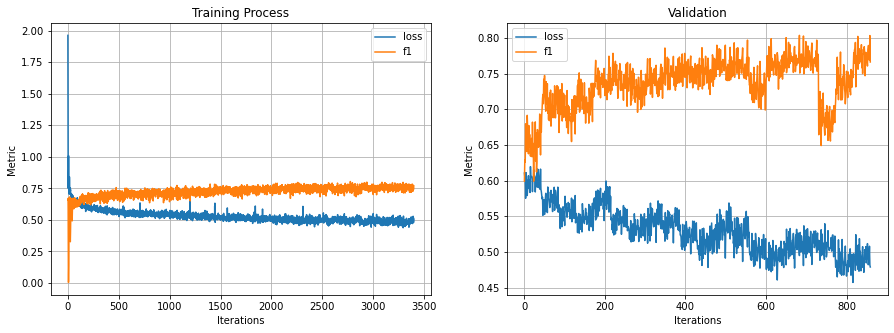

In [39]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

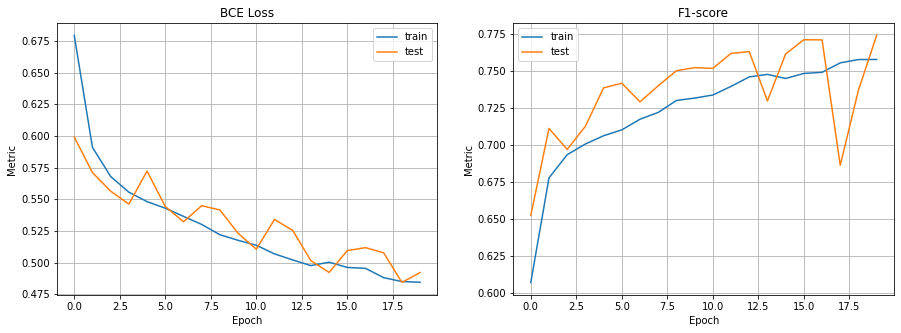

In [40]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

Так, это какой-то новый вид приколов)) Лернинг рейту больше не наливаем.

In [41]:
print(
    'WS-CNN с dropout, нормализацией и weight decay (lr=0.0005): \
loss = {}, f1 = {}'.format(initial_ws2_loss, initial_ws2_f1))

initial_ws3_loss = np.mean(losses_eval[-1])
initial_ws3_f1 = np.mean(f1s_eval[-1])
print(
    'WS-CNN с dropout, нормализацией и weight decay (lr=0.001): \
loss = {}, f1 = {}'.format(initial_ws3_loss, initial_ws3_f1))

WS-CNN с dropout, нормализацией и weight decay (lr=0.0005): loss = 0.5043005361113437, f1 = 0.7473658919334412
WS-CNN с dropout, нормализацией и weight decay (lr=0.001): loss = 0.492161468017933, f1 = 0.7738071084022522


Здесь видно, что метрики немного улучшились, но это больше похоже на везение, и останавливаться на этой модели как-то не хочется.

#### Еще раз weight decay
Возвращаемся к параметрам из предыдущего эксперимента: оставляем dropout и нормализацию, возвращаем learning rate = 0.0005 и уменьшаем weight decay.

In [43]:
ws4_model = WS_CNN1(len(token2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(ws4_model.parameters(),
                       lr=0.0005, weight_decay=1e-5)
criterion = nn.BCELoss()

ws4_model = ws4_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [44]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(ws4_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.7399080237921547, Train f1: 0.5424197316169739
Train loss: 0.7109251285300535, Train f1: 0.5704642534255981
Train loss: 0.6932573534694373, Train f1: 0.5855041146278381
Train loss: 0.6801608459037893, Train f1: 0.5997635126113892
Train loss: 0.6694021754405077, Train f1: 0.6104502081871033

Validating...

Val loss: 0.6111552268266678, Val f1: 0.7036046981811523
Val loss: 0.6128974109888077, Val f1: 0.7063244581222534
Val loss: 0.6138366982340813, Val f1: 0.7040843963623047
Val loss: 0.6153613496571779, Val f1: 0.7020576596260071
Val loss: 0.6159588068723678, Val f1: 0.7014942169189453

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6125276562045602, Train f1: 0.6602634191513062
Train loss: 0.6077024007544798, Train f1: 0.6655712723731995
Train loss: 0.6039378228140813, Train f1: 0.6658595204353333
Train loss: 0.6001681654768831, Train f1: 0.668891429901123
Train loss: 0.5971287744886735, Train f1: 0.6714110374450684

Validating...

Val loss: 0.578494094312191, Val f1: 0.7245355844497681
Val loss: 0.5800609365105629, Val f1: 0.726223349571228
Val loss: 0.5800764312346777, Val f1: 0.724698543548584
Val loss: 0.5818772185593843, Val f1: 0.7226063013076782
Val loss: 0.5825686246156693, Val f1: 0.72264164686203

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5749184822334963, Train f1: 0.6873295903205872
Train loss: 0.5745705445023144, Train f1: 0.6865344643592834
Train loss: 0.5725561824499392, Train f1: 0.688124418258667
Train loss: 0.5718187851940885, Train f1: 0.6892997026443481
Train loss: 0.5699869548573213, Train f1: 0.6904746294021606

Validating...

Val loss: 0.5590962693095207, Val f1: 0.731261134147644
Val loss: 0.5606755241751671, Val f1: 0.7311388254165649
Val loss: 0.5605856279532114, Val f1: 0.7304751873016357
Val loss: 0.5622340831905603, Val f1: 0.7281079292297363
Val loss: 0.5630344599485397, Val f1: 0.727809488773346

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5612305437817293, Train f1: 0.6968260407447815
Train loss: 0.5591628525186988, Train f1: 0.6996539831161499
Train loss: 0.5569482971640194, Train f1: 0.7009835243225098
Train loss: 0.5543048776247922, Train f1: 0.7022389769554138
Train loss: 0.5531360717380748, Train f1: 0.7041133046150208

Validating...

Val loss: 0.5550065487623215, Val f1: 0.7389434576034546
Val loss: 0.5561855845153332, Val f1: 0.7377412915229797
Val loss: 0.555815060933431, Val f1: 0.7374879717826843
Val loss: 0.5571273639798164, Val f1: 0.7354594469070435
Val loss: 0.5581218093633652, Val f1: 0.7354248762130737

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5398740452878615, Train f1: 0.7173447608947754
Train loss: 0.5400402427596205, Train f1: 0.7146872282028198
Train loss: 0.5399427218180076, Train f1: 0.716431736946106
Train loss: 0.5382202843971112, Train f1: 0.71795654296875
Train loss: 0.5372631053714191, Train f1: 0.7187826633453369

Validating...

Val loss: 0.5289258658885956, Val f1: 0.7393441200256348
Val loss: 0.5311361663043499, Val f1: 0.736942708492279
Val loss: 0.5309700245658556, Val f1: 0.7371349930763245
Val loss: 0.5318807102739811, Val f1: 0.734821081161499
Val loss: 0.5329079359769822, Val f1: 0.7343164682388306

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.534015459172866, Train f1: 0.7161859273910522
Train loss: 0.5296853815808016, Train f1: 0.7200776934623718
Train loss: 0.5286618287072462, Train f1: 0.7235137224197388
Train loss: 0.5264975487747613, Train f1: 0.7253084778785706
Train loss: 0.5257172738804536, Train f1: 0.7268807291984558

Validating...

Val loss: 0.5192321389913559, Val f1: 0.7488466501235962
Val loss: 0.5218018032610416, Val f1: 0.7483752965927124
Val loss: 0.5209473222494125, Val f1: 0.7490127086639404
Val loss: 0.5216206479817629, Val f1: 0.7467873096466064
Val loss: 0.5228900745511055, Val f1: 0.7463350892066956

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5176141560077667, Train f1: 0.731616199016571
Train loss: 0.5167856299701858, Train f1: 0.7346242070198059
Train loss: 0.5162354923930823, Train f1: 0.7367996573448181
Train loss: 0.5146614438032403, Train f1: 0.7363240718841553
Train loss: 0.5146706156870898, Train f1: 0.7364041209220886

Validating...

Val loss: 0.5299641117453575, Val f1: 0.7564278244972229
Val loss: 0.5313805676996708, Val f1: 0.7546342611312866
Val loss: 0.5302081058422724, Val f1: 0.7550258040428162
Val loss: 0.5307556726038456, Val f1: 0.7537606954574585
Val loss: 0.531963287293911, Val f1: 0.7539913654327393

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5093795087407617, Train f1: 0.745156466960907
Train loss: 0.5075244824675953, Train f1: 0.7449500560760498
Train loss: 0.5053154370364021, Train f1: 0.7446245551109314
Train loss: 0.5046405739643994, Train f1: 0.744666337966919
Train loss: 0.5041481738581377, Train f1: 0.7458972930908203

Validating...

Val loss: 0.5276429280638695, Val f1: 0.7611132860183716
Val loss: 0.5292269289493561, Val f1: 0.7589878439903259
Val loss: 0.5276346479852995, Val f1: 0.7592141032218933
Val loss: 0.527799354866147, Val f1: 0.7596224546432495
Val loss: 0.5290073022246361, Val f1: 0.7594534158706665

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.49403785081470714, Train f1: 0.7543448805809021
Train loss: 0.49747435529442396, Train f1: 0.7502070069313049
Train loss: 0.4955771693996355, Train f1: 0.7513105869293213
Train loss: 0.496017711565775, Train f1: 0.7519932985305786
Train loss: 0.4952942579984665, Train f1: 0.7524242401123047

Validating...

Val loss: 0.5011773183941841, Val f1: 0.7633310556411743
Val loss: 0.5033138580620289, Val f1: 0.7624045610427856
Val loss: 0.5020613111555576, Val f1: 0.7625778317451477
Val loss: 0.501977046020329, Val f1: 0.761303186416626
Val loss: 0.5028773963451385, Val f1: 0.7612309455871582

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.48933838307857513, Train f1: 0.7538082599639893
Train loss: 0.4896942434065482, Train f1: 0.7560648918151855
Train loss: 0.48911680485688, Train f1: 0.7573535442352295
Train loss: 0.48825180223759485, Train f1: 0.758646547794342
Train loss: 0.4880213672623915, Train f1: 0.7580901384353638

Validating...

Val loss: 0.5014415718615055, Val f1: 0.7663142681121826
Val loss: 0.5039896555244923, Val f1: 0.7665432691574097
Val loss: 0.5024323749045531, Val f1: 0.7679634094238281
Val loss: 0.5020785685628653, Val f1: 0.7676371932029724
Val loss: 0.5031744174659252, Val f1: 0.7678729295730591

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4777305345324909, Train f1: 0.7656686305999756
Train loss: 0.47941834348089557, Train f1: 0.7654659748077393
Train loss: 0.48067911495180693, Train f1: 0.7634549736976624
Train loss: 0.47952915399390106, Train f1: 0.7643492817878723
Train loss: 0.47896827739827774, Train f1: 0.7653588056564331

Validating...

Val loss: 0.4967203959822655, Val f1: 0.768517255783081
Val loss: 0.4992594551295042, Val f1: 0.766759991645813
Val loss: 0.4971679151058197, Val f1: 0.7690699696540833
Val loss: 0.49683759082108736, Val f1: 0.7684798240661621
Val loss: 0.4980986550450325, Val f1: 0.7680026292800903

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4754662504967521, Train f1: 0.7695364952087402
Train loss: 0.4733448624610901, Train f1: 0.7714937925338745
Train loss: 0.4732085200501423, Train f1: 0.7703538537025452
Train loss: 0.4719780611202997, Train f1: 0.7703630924224854
Train loss: 0.47219251850072075, Train f1: 0.7697911858558655

Validating...

Val loss: 0.48672396689653397, Val f1: 0.7680070400238037
Val loss: 0.48906379751861095, Val f1: 0.7680720686912537
Val loss: 0.4874056664605935, Val f1: 0.7690277695655823
Val loss: 0.48692286387085915, Val f1: 0.7685222029685974
Val loss: 0.48811999410390855, Val f1: 0.7682458162307739

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.46230098605155945, Train f1: 0.7737984657287598
Train loss: 0.4629937883685617, Train f1: 0.775257408618927
Train loss: 0.46548480467469083, Train f1: 0.7727215886116028
Train loss: 0.4651873433852897, Train f1: 0.7732581496238708
Train loss: 0.46527887442532706, Train f1: 0.7737233638763428

Validating...

Val loss: 0.4799422398209572, Val f1: 0.7624971866607666
Val loss: 0.48254079930484295, Val f1: 0.7610960006713867
Val loss: 0.4807213420669238, Val f1: 0.761509895324707
Val loss: 0.4802593542262912, Val f1: 0.7615918517112732
Val loss: 0.4814099371433258, Val f1: 0.7613358497619629

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.454789194114068, Train f1: 0.7805201411247253
Train loss: 0.4571358785033226, Train f1: 0.7795734405517578
Train loss: 0.45914603039330126, Train f1: 0.7788496613502502
Train loss: 0.4591270242543781, Train f1: 0.7789222598075867
Train loss: 0.4596086207558127, Train f1: 0.7793541550636292

Validating...

Val loss: 0.4890180230140686, Val f1: 0.7704891562461853
Val loss: 0.49090311862528324, Val f1: 0.7698689699172974
Val loss: 0.4885634171466033, Val f1: 0.7721099853515625
Val loss: 0.4879930280148983, Val f1: 0.77256840467453
Val loss: 0.48952452167868615, Val f1: 0.7724173665046692

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4505850260748583, Train f1: 0.7859118580818176
Train loss: 0.44968509367283654, Train f1: 0.7871243953704834
Train loss: 0.4504881121364294, Train f1: 0.7858001589775085
Train loss: 0.4535578883746091, Train f1: 0.7852414846420288
Train loss: 0.45375846729559055, Train f1: 0.7842867970466614

Validating...

Val loss: 0.4781482182443142, Val f1: 0.7714982032775879
Val loss: 0.479825884103775, Val f1: 0.7708085775375366
Val loss: 0.4778023920953274, Val f1: 0.7710307240486145
Val loss: 0.47728942707180977, Val f1: 0.7717043161392212
Val loss: 0.47863048911094663, Val f1: 0.7709001302719116

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4482602994231617, Train f1: 0.7829794883728027
Train loss: 0.4475638060008778, Train f1: 0.785706102848053
Train loss: 0.44486917000190884, Train f1: 0.787079930305481
Train loss: 0.44727710722123876, Train f1: 0.7861455082893372
Train loss: 0.4476147975991754, Train f1: 0.7857863306999207

Validating...

Val loss: 0.4914576932787895, Val f1: 0.7706547975540161
Val loss: 0.4937405604869127, Val f1: 0.7702707648277283
Val loss: 0.4911302986244361, Val f1: 0.7714899182319641
Val loss: 0.4901925986632705, Val f1: 0.772394597530365
Val loss: 0.4920153275132179, Val f1: 0.7721320390701294

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4411969675737269, Train f1: 0.7945672869682312
Train loss: 0.43915926139144335, Train f1: 0.7935874462127686
Train loss: 0.4397691643121196, Train f1: 0.7930267453193665
Train loss: 0.4394006238264196, Train f1: 0.7926660180091858
Train loss: 0.4401596018496682, Train f1: 0.7916647791862488

Validating...

Val loss: 0.4734270013868809, Val f1: 0.7612555027008057
Val loss: 0.4750015661120415, Val f1: 0.7622683048248291
Val loss: 0.4727949934701125, Val f1: 0.7639565467834473
Val loss: 0.4723234297707677, Val f1: 0.7641375064849854
Val loss: 0.47338066771626475, Val f1: 0.7639182806015015

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4311490050133537, Train f1: 0.7955365180969238
Train loss: 0.43203096486189785, Train f1: 0.796212911605835
Train loss: 0.43433476224833845, Train f1: 0.7956569194793701
Train loss: 0.4348873741486493, Train f1: 0.7960394620895386
Train loss: 0.43489922127302955, Train f1: 0.795158863067627

Validating...

Val loss: 0.4728967696428299, Val f1: 0.7672404050827026
Val loss: 0.4745073951780796, Val f1: 0.7679025530815125
Val loss: 0.47174203271667164, Val f1: 0.7696090340614319
Val loss: 0.4710695669054985, Val f1: 0.7708863019943237
Val loss: 0.47227061316370966, Val f1: 0.7701977491378784

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.42862341596799736, Train f1: 0.8022093772888184
Train loss: 0.4271112325436929, Train f1: 0.8021731376647949
Train loss: 0.4295753471407236, Train f1: 0.8002642393112183
Train loss: 0.4304027695427923, Train f1: 0.7992426753044128
Train loss: 0.43068317560588615, Train f1: 0.7986764311790466

Validating...

Val loss: 0.4773401506245136, Val f1: 0.7603707313537598
Val loss: 0.47856351360678673, Val f1: 0.7587646245956421
Val loss: 0.47560768698652583, Val f1: 0.7593856453895569
Val loss: 0.47445129603147507, Val f1: 0.7596050500869751
Val loss: 0.47580111846327783, Val f1: 0.7593080401420593

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4224725242923288, Train f1: 0.806000828742981
Train loss: 0.4218338596470216, Train f1: 0.8045875430107117
Train loss: 0.4223218887459998, Train f1: 0.803167462348938
Train loss: 0.42289191484451294, Train f1: 0.8023410439491272
Train loss: 0.4250191495699041, Train f1: 0.8009533882141113

Validating...

Val loss: 0.4782532714307308, Val f1: 0.7698789238929749
Val loss: 0.47747184336185455, Val f1: 0.7713695168495178
Val loss: 0.4751141058901946, Val f1: 0.772656261920929
Val loss: 0.47389652021229267, Val f1: 0.7735571265220642
Val loss: 0.47521335631608963, Val f1: 0.7726312875747681


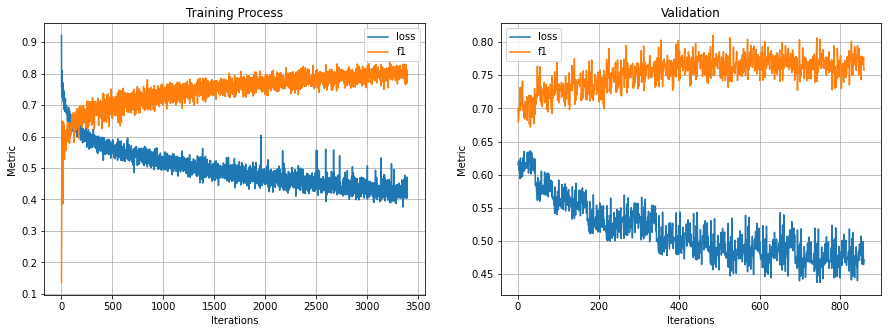

In [45]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

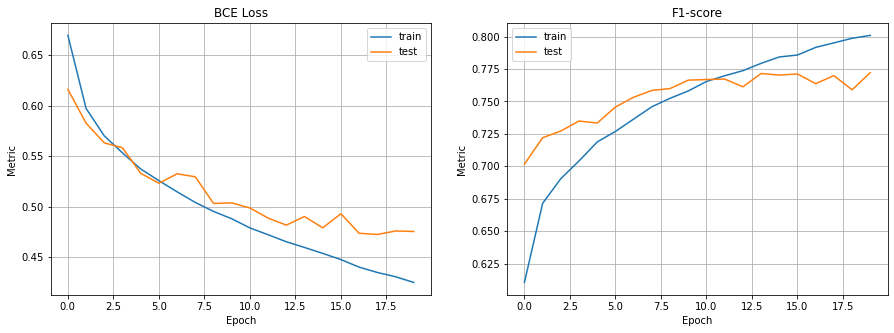

In [46]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

Ага, стало получше, хотя похоже, что мы накрутили лишних эпох. Время поджимает, поэтому переучивать на меньшем числе я не буду, сначала попробуем другие штуки.

In [47]:
print(
    'WS-CNN с dropout, нормализацией и weight_decay = 1e-4: \
loss = {}, f1 = {}'.format(initial_ws2_loss, initial_ws2_f1))

initial_ws4_loss = np.mean(losses_eval[-1])
initial_ws4_f1 = np.mean(f1s_eval[-1])
print(
    'WS-CNN с dropout, нормализацией и weight_decay = 1e-5: \
loss = {}, f1 = {}'.format(initial_ws4_loss, initial_ws4_f1))

WS-CNN с dropout, нормализацией и weight_decay = 1e-4: loss = 0.5043005361113437, f1 = 0.7473658919334412
WS-CNN с dropout, нормализацией и weight_decay = 1e-5: loss = 0.4754347128923549, f1 = 0.7722194790840149


Значения приятные!
#### Архитектура модели
Увеличим число фичей у сверточных слоев и добавим еще один линейный слой. Остальные параметры оставляем (в том числе и weight decay = 1e-5, он хоть и не дает прироста f1, но снижает лосс и, главное, помогает с переобучением).

In [51]:
class WS_CNN2(nn.Module):

    def __init__(self, token_vocab_size, symbol_vocab_size,
                 token_embedding_dim, symbol_embedding_dim):

        super().__init__()

        # эмбеддинг-слой для слов
        self.token_embedding = nn.Embedding(token_vocab_size,
                                            token_embedding_dim)
        # нормализация
        self.token_batch_norm = nn.BatchNorm1d(100)
        self.token_hidden = nn.Linear(in_features=token_embedding_dim,
                                      out_features=100)

        # эмбеддинг-слой для символов
        self.symbol_embedding = nn.Embedding(symbol_vocab_size,
                                             symbol_embedding_dim)
        # биграммная свертка
        self.symbol_bigrams = nn.Conv1d(in_channels=symbol_embedding_dim,
                                        out_channels=200, kernel_size=2,
                                        padding='same')
        # триграммная свертка
        self.symbol_trigrams = nn.Conv1d(in_channels=symbol_embedding_dim,
                                         out_channels=100, kernel_size=3,
                                         padding='same')
        self.symbol_hidden = nn.Linear(in_features=300,
                                       out_features=100)

        # нормализация
        self.batch_norm2 = nn.BatchNorm1d(200)
        self.batch_norm3 = nn.BatchNorm1d(100)

        self.hidden = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.out = nn.Sigmoid()

    def forward(self, token_seq, symbol_seq):

        # вектор слов
        embedded_tokens = torch.mean(self.token_embedding(token_seq), dim=1)
        token_vector = self.token_batch_norm(self.dropout(
            self.relu(self.token_hidden(embedded_tokens))))

        # символьные эмбеддинги
        embedded_symbols = self.symbol_embedding(symbol_seq)
        embedded_symbols = embedded_symbols.transpose(1, 2)

        # сверточные слои
        feature_map_bigrams = self.batch_norm2(self.dropout(
            self.relu(self.symbol_bigrams(embedded_symbols))))
        feature_map_trigrams = self.batch_norm3(self.dropout(
            self.relu(self.symbol_trigrams(embedded_symbols))))

        # пулинг
        pooling1 = feature_map_bigrams.max(2)[0]
        pooling2 = feature_map_trigrams.max(2)[0]

        # конкатенация символьных слоев
        concat1 = self.symbol_hidden(torch.cat((pooling1, pooling2), 1))

        # конкатенация всего
        concat2 = torch.cat((concat1, token_vector), 1)

        # линейный слой + сигмоида
        logits = self.hidden(concat2)
        logits = self.out(logits)

        return logits

In [52]:
ws5_model = WS_CNN2(len(token2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(ws5_model.parameters(),
                       lr=0.0005, weight_decay=1e-5)
criterion = nn.BCELoss()

ws5_model = ws5_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [53]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(ws5_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=20)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.7548780125730178, Train f1: 0.4996754825115204
Train loss: 0.7048286164508146, Train f1: 0.5619420409202576
Train loss: 0.6832564730270236, Train f1: 0.5888248682022095
Train loss: 0.6690014543778756, Train f1: 0.6016333103179932
Train loss: 0.6575995767817778, Train f1: 0.6118719577789307

Validating...

Val loss: 0.6067115515470505, Val f1: 0.7039481401443481
Val loss: 0.606450330466032, Val f1: 0.7062338590621948
Val loss: 0.6058831339081129, Val f1: 0.7055439352989197
Val loss: 0.6064232531934977, Val f1: 0.7029300928115845
Val loss: 0.6062388479709625, Val f1: 0.7044665217399597

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5975789620595819, Train f1: 0.67573481798172
Train loss: 0.5961731505744597, Train f1: 0.6716048717498779
Train loss: 0.5951426373977288, Train f1: 0.6699243187904358
Train loss: 0.5928449836723945, Train f1: 0.6717909574508667
Train loss: 0.59001124921967, Train f1: 0.6741329431533813

Validating...

Val loss: 0.582851879298687, Val f1: 0.721819281578064
Val loss: 0.5837538354098797, Val f1: 0.7230634689331055
Val loss: 0.5827658052245775, Val f1: 0.7224182486534119
Val loss: 0.5834600832313299, Val f1: 0.7213233709335327
Val loss: 0.5834714695811272, Val f1: 0.7225911021232605

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5759089431341957, Train f1: 0.6757470965385437
Train loss: 0.5732413547880509, Train f1: 0.6837771534919739
Train loss: 0.5717231812430363, Train f1: 0.6854867339134216
Train loss: 0.5694515367641169, Train f1: 0.6890778541564941
Train loss: 0.5676460476482615, Train f1: 0.691782534122467

Validating...

Val loss: 0.5743266046047211, Val f1: 0.7301840782165527
Val loss: 0.5746206566691399, Val f1: 0.7307502031326294
Val loss: 0.5734634374578794, Val f1: 0.7301425337791443
Val loss: 0.5738611407577991, Val f1: 0.7293868064880371
Val loss: 0.5739289328455925, Val f1: 0.730933666229248

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5544188671252307, Train f1: 0.7002023458480835
Train loss: 0.554333194213755, Train f1: 0.701723575592041
Train loss: 0.5525906383991241, Train f1: 0.704168438911438
Train loss: 0.5512888339512488, Train f1: 0.7042648196220398
Train loss: 0.5509761431637932, Train f1: 0.705183207988739

Validating...

Val loss: 0.5873389542102814, Val f1: 0.7306188941001892
Val loss: 0.5875591970980167, Val f1: 0.7304697632789612
Val loss: 0.5858495558301607, Val f1: 0.7324655652046204
Val loss: 0.5857828855514526, Val f1: 0.7332195043563843
Val loss: 0.5859224602580071, Val f1: 0.7338172197341919

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.541591639027876, Train f1: 0.7122170925140381
Train loss: 0.5414787522133659, Train f1: 0.7123861908912659
Train loss: 0.5409371911310682, Train f1: 0.7130166888237
Train loss: 0.5380370726480204, Train f1: 0.7166985869407654
Train loss: 0.538097022561466, Train f1: 0.7169771790504456

Validating...

Val loss: 0.5558259040117264, Val f1: 0.7436995506286621
Val loss: 0.5565680116415024, Val f1: 0.7435033321380615
Val loss: 0.5550108949343363, Val f1: 0.7452751994132996
Val loss: 0.5548417437821627, Val f1: 0.7450439929962158
Val loss: 0.5550458371639252, Val f1: 0.7454262971878052

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5321753813939936, Train f1: 0.7223310470581055
Train loss: 0.530333440969972, Train f1: 0.7217010855674744
Train loss: 0.5285850798382479, Train f1: 0.7227442860603333
Train loss: 0.5285878091612283, Train f1: 0.7231612205505371
Train loss: 0.5267561281428618, Train f1: 0.7252383828163147

Validating...

Val loss: 0.5277920737862587, Val f1: 0.7487121224403381
Val loss: 0.5285111293196678, Val f1: 0.7472518682479858
Val loss: 0.5273023123542467, Val f1: 0.7473017573356628
Val loss: 0.5267697526142001, Val f1: 0.7459900379180908
Val loss: 0.526931843906641, Val f1: 0.7467818260192871

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5196025099824456, Train f1: 0.7297781705856323
Train loss: 0.5170484369291979, Train f1: 0.733198344707489
Train loss: 0.5182107231196236, Train f1: 0.7318828701972961
Train loss: 0.5155042464680532, Train f1: 0.7340120673179626
Train loss: 0.5165088499293607, Train f1: 0.7331905961036682

Validating...

Val loss: 0.5492342635989189, Val f1: 0.7481098175048828
Val loss: 0.5506569817662239, Val f1: 0.7480836510658264
Val loss: 0.5490017260114352, Val f1: 0.750126838684082
Val loss: 0.5480702333152294, Val f1: 0.7507883310317993
Val loss: 0.5486167043447494, Val f1: 0.7514114379882812

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5109198996249367, Train f1: 0.7378555536270142
Train loss: 0.5061137040748316, Train f1: 0.741420328617096
Train loss: 0.5071432359662711, Train f1: 0.7424541711807251
Train loss: 0.5063500605961856, Train f1: 0.7426944971084595
Train loss: 0.5055800315211801, Train f1: 0.7430769205093384

Validating...

Val loss: 0.5167942456901073, Val f1: 0.7585846781730652
Val loss: 0.5185506287962198, Val f1: 0.7576853632926941
Val loss: 0.5172709276278814, Val f1: 0.758308470249176
Val loss: 0.5162404198199511, Val f1: 0.7587474584579468
Val loss: 0.516727463901043, Val f1: 0.7598632574081421

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.49650024403544035, Train f1: 0.7496970891952515
Train loss: 0.49729958746363134, Train f1: 0.7469868063926697
Train loss: 0.49707286176728266, Train f1: 0.7484017014503479
Train loss: 0.49689458310604095, Train f1: 0.7489049434661865
Train loss: 0.49659442428280326, Train f1: 0.7504870891571045

Validating...

Val loss: 0.5043292231857777, Val f1: 0.76373291015625
Val loss: 0.5057380963116884, Val f1: 0.7627121210098267
Val loss: 0.5050352588295937, Val f1: 0.7621977925300598
Val loss: 0.5042266752570868, Val f1: 0.7616071701049805
Val loss: 0.5048244521021843, Val f1: 0.7619905471801758

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.48597248862771425, Train f1: 0.7584719657897949
Train loss: 0.48803410328486385, Train f1: 0.7565712332725525
Train loss: 0.49010878596820084, Train f1: 0.7554832100868225
Train loss: 0.4901937526815078, Train f1: 0.7550264000892639
Train loss: 0.49035770069150364, Train f1: 0.7546826601028442

Validating...

Val loss: 0.5048547238111496, Val f1: 0.7657867074012756
Val loss: 0.5064731724560261, Val f1: 0.7654805183410645
Val loss: 0.5058525453011194, Val f1: 0.7655079960823059
Val loss: 0.5043062344193459, Val f1: 0.7655518054962158
Val loss: 0.5052754119038582, Val f1: 0.7659446001052856

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4838739326771568, Train f1: 0.7606129050254822
Train loss: 0.4810665679328582, Train f1: 0.7624745965003967
Train loss: 0.4813952466436461, Train f1: 0.7610176205635071
Train loss: 0.4825308818150969, Train f1: 0.7601293921470642
Train loss: 0.4820635867469451, Train f1: 0.7602116465568542

Validating...

Val loss: 0.49493685364723206, Val f1: 0.7678043842315674
Val loss: 0.4969820585101843, Val f1: 0.7675278186798096
Val loss: 0.49669739603996277, Val f1: 0.7665414214134216
Val loss: 0.49541211500763893, Val f1: 0.7664659023284912
Val loss: 0.49614730924367906, Val f1: 0.7666908502578735

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4777891942683388, Train f1: 0.7657591700553894
Train loss: 0.4744437507846776, Train f1: 0.7677866220474243
Train loss: 0.475466081032566, Train f1: 0.7661058306694031
Train loss: 0.4761794025407118, Train f1: 0.7652565836906433
Train loss: 0.47558961913866155, Train f1: 0.7659981846809387

Validating...

Val loss: 0.49158886075019836, Val f1: 0.7706798911094666
Val loss: 0.4928245022892952, Val f1: 0.7709060311317444
Val loss: 0.4922389214237531, Val f1: 0.7705084681510925
Val loss: 0.4913279479369521, Val f1: 0.7707129716873169
Val loss: 0.492365300655365, Val f1: 0.7706893086433411

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.46537365983514223, Train f1: 0.7746825814247131
Train loss: 0.4669399331597721, Train f1: 0.7713185548782349
Train loss: 0.4679172708123338, Train f1: 0.7719101905822754
Train loss: 0.46710211301551147, Train f1: 0.7713237404823303
Train loss: 0.46744705333429226, Train f1: 0.7706270217895508

Validating...

Val loss: 0.49643030017614365, Val f1: 0.7688944339752197
Val loss: 0.4977379348129034, Val f1: 0.7695509195327759
Val loss: 0.4973802293340365, Val f1: 0.769585132598877
Val loss: 0.49598028138279915, Val f1: 0.7695721387863159
Val loss: 0.49720512703061104, Val f1: 0.7696824669837952

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4613870505024405, Train f1: 0.7770878672599792
Train loss: 0.459815391284578, Train f1: 0.7790849208831787
Train loss: 0.46402370608320426, Train f1: 0.7762450575828552
Train loss: 0.46337270912002115, Train f1: 0.7766444087028503
Train loss: 0.4625849641421262, Train f1: 0.7770481705665588

Validating...

Val loss: 0.47828368097543716, Val f1: 0.770288348197937
Val loss: 0.4801264889538288, Val f1: 0.7697252631187439
Val loss: 0.4801109917461872, Val f1: 0.7693822979927063
Val loss: 0.479000355117023, Val f1: 0.7694854736328125
Val loss: 0.4802041590213776, Val f1: 0.76997309923172

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4532160811564502, Train f1: 0.7795532941818237
Train loss: 0.4550961111398304, Train f1: 0.7796036005020142
Train loss: 0.45658572135018366, Train f1: 0.779064416885376
Train loss: 0.4571193634148906, Train f1: 0.7794753313064575
Train loss: 0.45646627738195306, Train f1: 0.7797647714614868

Validating...

Val loss: 0.483929805457592, Val f1: 0.7739169597625732
Val loss: 0.48529749922454357, Val f1: 0.773780107498169
Val loss: 0.48438164095083874, Val f1: 0.7742422223091125
Val loss: 0.4830218069255352, Val f1: 0.7755298018455505
Val loss: 0.484738976508379, Val f1: 0.7751754522323608

Training...


Epoch 16:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.44502347094171185, Train f1: 0.7867545485496521
Train loss: 0.4456686175921384, Train f1: 0.7855805158615112
Train loss: 0.4487148631437152, Train f1: 0.7856625318527222
Train loss: 0.45036182136220093, Train f1: 0.7850462794303894
Train loss: 0.4506959731087965, Train f1: 0.7848688364028931

Validating...

Val loss: 0.480683583766222, Val f1: 0.7751767635345459
Val loss: 0.48207753896713257, Val f1: 0.7764507532119751
Val loss: 0.4815940049787362, Val f1: 0.7768816947937012
Val loss: 0.4802184924483299, Val f1: 0.7773895263671875
Val loss: 0.4815346926450729, Val f1: 0.7767084836959839

Training...


Epoch 17:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4394810313687605, Train f1: 0.7883069515228271
Train loss: 0.44126761003452186, Train f1: 0.7884258031845093
Train loss: 0.44366200881845813, Train f1: 0.7875398397445679
Train loss: 0.4441671538002351, Train f1: 0.7884804010391235
Train loss: 0.44477528842056496, Train f1: 0.7885887622833252

Validating...

Val loss: 0.5028382875025272, Val f1: 0.77643883228302
Val loss: 0.5042613688856363, Val f1: 0.7766013145446777
Val loss: 0.50308749700586, Val f1: 0.7763504981994629
Val loss: 0.5012877071276307, Val f1: 0.7763895988464355
Val loss: 0.5029602907598019, Val f1: 0.7768511176109314

Training...


Epoch 18:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4366126025424284, Train f1: 0.795596182346344
Train loss: 0.4361073348452063, Train f1: 0.7965131402015686
Train loss: 0.43667695335313383, Train f1: 0.7946832776069641
Train loss: 0.437260275158812, Train f1: 0.7936084866523743
Train loss: 0.4373077616972082, Train f1: 0.7938145399093628

Validating...

Val loss: 0.49499348923563957, Val f1: 0.775870144367218
Val loss: 0.49613670632243156, Val f1: 0.776735782623291
Val loss: 0.49509591112534207, Val f1: 0.7767269015312195
Val loss: 0.49266738165169954, Val f1: 0.7770569920539856
Val loss: 0.49509264156222343, Val f1: 0.7768813371658325

Training...


Epoch 19:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4335878386217005, Train f1: 0.7933284640312195
Train loss: 0.4316426116754027, Train f1: 0.7959802150726318
Train loss: 0.4312281310558319, Train f1: 0.7969195246696472
Train loss: 0.43093470878460827, Train f1: 0.79681396484375
Train loss: 0.4326020682559294, Train f1: 0.7955950498580933

Validating...

Val loss: 0.4935626834630966, Val f1: 0.781522274017334
Val loss: 0.4949524011462927, Val f1: 0.7800954580307007
Val loss: 0.4936298814912637, Val f1: 0.7808771133422852
Val loss: 0.4918279219418764, Val f1: 0.7808277606964111
Val loss: 0.49402512460947035, Val f1: 0.7807270288467407

Training...


Epoch 20:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.42605817493270426, Train f1: 0.8000202775001526
Train loss: 0.4248831250211772, Train f1: 0.8003013134002686
Train loss: 0.4255702784832786, Train f1: 0.8003258109092712
Train loss: 0.42975589895949645, Train f1: 0.7978917360305786
Train loss: 0.4296223040889291, Train f1: 0.7979966998100281

Validating...

Val loss: 0.4767688065767288, Val f1: 0.7787918448448181
Val loss: 0.47875055111944675, Val f1: 0.7763458490371704
Val loss: 0.4771498180925846, Val f1: 0.7771254181861877
Val loss: 0.4749914826825261, Val f1: 0.7780018448829651
Val loss: 0.4772508926689625, Val f1: 0.7778984904289246


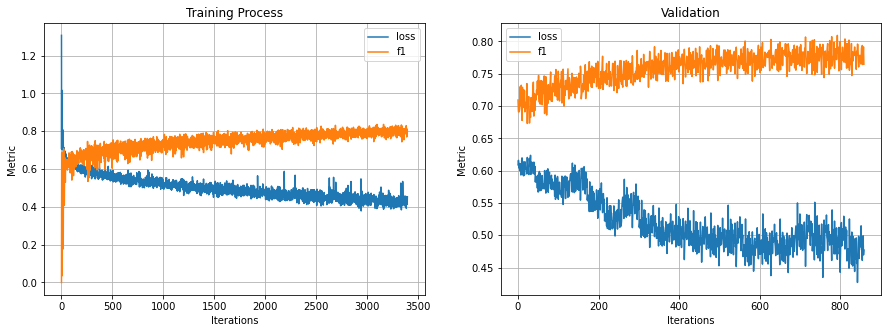

In [54]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

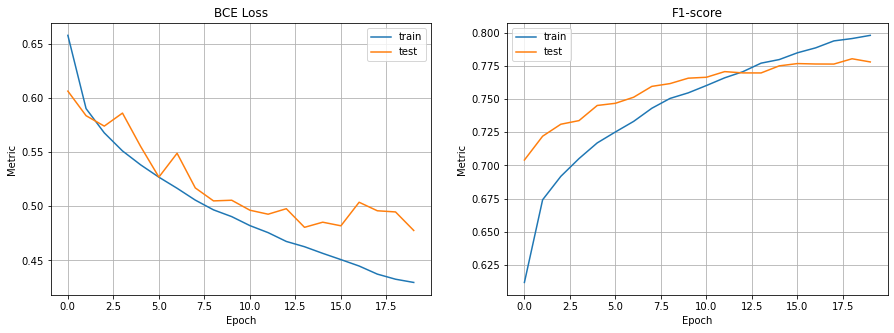

In [55]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

Здесь не так скачет f1, а с лоссом все по-прежнему, и опять есть подозрение на лишние эпохи...

In [56]:
print(
    'WS-CNN с dropout, нормализацией и weight_decay = 1e-5: \
loss = {}, f1 = {}'.format(initial_ws4_loss, initial_ws4_f1))

initial_ws5_loss = np.mean(losses_eval[-1])
initial_ws5_f1 = np.mean(f1s_eval[-1])
print(
    'WS-CNN с другими размерностями и новым линейным слоем: \
loss = {}, f1 = {}'.format(initial_ws5_loss, initial_ws5_f1))

WS-CNN с dropout, нормализацией и weight_decay = 1e-5: loss = 0.4754347128923549, f1 = 0.7722194790840149
WS-CNN с другими размерностями и новым линейным слоем: loss = 0.47757779235063597, f1 = 0.7779678702354431


Почти ничего не изменилось, но бОльшая стабильность f1 -- вроде как плюс.
#### Число эпох
Уменьшим число эпох до 15. (Это уже не улучшение, а попытка проверить гипотезу о том, что мы накручиваем лишние эпохи.)

In [59]:
ws6_model = WS_CNN2(len(token2id), len(symbol2id), 100, 10)
optimizer = optim.Adam(ws6_model.parameters(),
                       lr=0.0005, weight_decay=1e-5)
criterion = nn.BCELoss()

ws6_model = ws6_model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [60]:
losses_train, losses_eval, f1s_train, f1s_eval = \
    train_and_evaluate(ws6_model, train_iterator, val_iterator,
                       optimizer, criterion, epochs=15)


Training...


Epoch 1:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.7272938524975496, Train f1: 0.5108384490013123
Train loss: 0.691809818148613, Train f1: 0.5630059838294983
Train loss: 0.6747914091044781, Train f1: 0.5909623503684998
Train loss: 0.6638010402812677, Train f1: 0.6052524447441101
Train loss: 0.6552503820727853, Train f1: 0.6162770390510559

Validating...

Val loss: 0.6105988100171089, Val f1: 0.70372074842453
Val loss: 0.6110668107867241, Val f1: 0.7026505470275879
Val loss: 0.6117526864012083, Val f1: 0.7011702060699463
Val loss: 0.6120131798088551, Val f1: 0.6994451284408569
Val loss: 0.6122582510113717, Val f1: 0.6993817687034607

Training...


Epoch 2:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.6089634123970481, Train f1: 0.6763149499893188
Train loss: 0.6080881015342825, Train f1: 0.6728789210319519
Train loss: 0.6045693363629135, Train f1: 0.6765256524085999
Train loss: 0.6015080450212255, Train f1: 0.6771935224533081
Train loss: 0.5984780753360075, Train f1: 0.6789116263389587

Validating...

Val loss: 0.5960138142108917, Val f1: 0.7264490127563477
Val loss: 0.5964069738984108, Val f1: 0.722743570804596
Val loss: 0.5972218066453934, Val f1: 0.7218344807624817
Val loss: 0.5977279152721167, Val f1: 0.7199571132659912
Val loss: 0.5980473056435585, Val f1: 0.7202222943305969

Training...


Epoch 3:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5814786570913651, Train f1: 0.6932060122489929
Train loss: 0.5778378625126446, Train f1: 0.6935405135154724
Train loss: 0.5743064950494206, Train f1: 0.6940211057662964
Train loss: 0.5723174955038464, Train f1: 0.695131242275238
Train loss: 0.5710060200270485, Train f1: 0.6961938142776489

Validating...

Val loss: 0.5599910020828247, Val f1: 0.734174370765686
Val loss: 0.5609018765389919, Val f1: 0.7326406240463257
Val loss: 0.5618940368294716, Val f1: 0.7306639552116394
Val loss: 0.5623347572982311, Val f1: 0.729250431060791
Val loss: 0.5629523009061813, Val f1: 0.7284215092658997

Training...


Epoch 4:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5625665363143472, Train f1: 0.7021164298057556
Train loss: 0.5585657393231112, Train f1: 0.7030934691429138
Train loss: 0.556522468141481, Train f1: 0.7036153674125671
Train loss: 0.5577336952966803, Train f1: 0.7004489898681641
Train loss: 0.5556589845348807, Train f1: 0.7020251154899597

Validating...

Val loss: 0.5489015728235245, Val f1: 0.7406262755393982
Val loss: 0.5497705154120922, Val f1: 0.7413448691368103
Val loss: 0.5506677826245626, Val f1: 0.7397955060005188
Val loss: 0.5508958231657743, Val f1: 0.7381123304367065
Val loss: 0.5517822191119194, Val f1: 0.7369968891143799

Training...


Epoch 5:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5342243033296922, Train f1: 0.7220323085784912
Train loss: 0.5364039128317553, Train f1: 0.7189184427261353
Train loss: 0.5363928915238848, Train f1: 0.7200689315795898
Train loss: 0.5369692427270553, Train f1: 0.7194222211837769
Train loss: 0.5356285528225058, Train f1: 0.7205657958984375

Validating...

Val loss: 0.5497932657599449, Val f1: 0.7466883659362793
Val loss: 0.5511065497994423, Val f1: 0.7462031841278076
Val loss: 0.5516166836023331, Val f1: 0.7464955449104309
Val loss: 0.551819197833538, Val f1: 0.7450104355812073
Val loss: 0.5528956577181816, Val f1: 0.7442143559455872

Training...


Epoch 6:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.530619807103101, Train f1: 0.7272759079933167
Train loss: 0.5287196978050119, Train f1: 0.7260982394218445
Train loss: 0.5280304177134645, Train f1: 0.7261968851089478
Train loss: 0.5270741866791949, Train f1: 0.7273300886154175
Train loss: 0.5253017954966601, Train f1: 0.7281500697135925

Validating...

Val loss: 0.5265762060880661, Val f1: 0.751487135887146
Val loss: 0.5279403440654278, Val f1: 0.7516161203384399
Val loss: 0.5284902403752009, Val f1: 0.7502534985542297
Val loss: 0.5282169841229916, Val f1: 0.7488048076629639
Val loss: 0.5294038951396942, Val f1: 0.7476793527603149

Training...


Epoch 7:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5146149370600196, Train f1: 0.7392339706420898
Train loss: 0.5130590095239527, Train f1: 0.7369779944419861
Train loss: 0.5162419343695921, Train f1: 0.7348577976226807
Train loss: 0.5148738098933416, Train f1: 0.7366886138916016
Train loss: 0.5142541909919066, Train f1: 0.7365854978561401

Validating...

Val loss: 0.5414386689662933, Val f1: 0.7540457248687744
Val loss: 0.541935384273529, Val f1: 0.7543836832046509
Val loss: 0.5422097171346346, Val f1: 0.7551366686820984
Val loss: 0.5418818891048431, Val f1: 0.752968430519104
Val loss: 0.5432916909456253, Val f1: 0.752508819103241

Training...


Epoch 8:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.5025655206512002, Train f1: 0.7489046454429626
Train loss: 0.5024326439289486, Train f1: 0.7477550506591797
Train loss: 0.5054793062747693, Train f1: 0.7463966608047485
Train loss: 0.5063303303630913, Train f1: 0.7439814209938049
Train loss: 0.507508130108609, Train f1: 0.7426972389221191

Validating...

Val loss: 0.5266264379024506, Val f1: 0.7592437267303467
Val loss: 0.5275621972978115, Val f1: 0.7602466344833374
Val loss: 0.5274676531553268, Val f1: 0.760388195514679
Val loss: 0.5270386803895235, Val f1: 0.7589092254638672
Val loss: 0.5282083868980407, Val f1: 0.7589586973190308

Training...


Epoch 9:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.49612299922634573, Train f1: 0.753919780254364
Train loss: 0.49465371975127387, Train f1: 0.7543208003044128
Train loss: 0.49642912342267875, Train f1: 0.7521652579307556
Train loss: 0.49503303888966055, Train f1: 0.7532143592834473
Train loss: 0.49508538842201233, Train f1: 0.7521239519119263

Validating...

Val loss: 0.5113945193588734, Val f1: 0.7604008316993713
Val loss: 0.5121863260865211, Val f1: 0.7616686224937439
Val loss: 0.5123367756605148, Val f1: 0.7613218426704407
Val loss: 0.5116399433463812, Val f1: 0.7594660520553589
Val loss: 0.5130837455391883, Val f1: 0.7596220970153809

Training...


Epoch 10:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4909140160855125, Train f1: 0.755416214466095
Train loss: 0.4928359840722645, Train f1: 0.7513628602027893
Train loss: 0.49169375908141044, Train f1: 0.7535192370414734
Train loss: 0.4901767401572536, Train f1: 0.7551745176315308
Train loss: 0.48991589528672835, Train f1: 0.7551583647727966

Validating...

Val loss: 0.5495449379086494, Val f1: 0.7541247606277466
Val loss: 0.5498527213931084, Val f1: 0.7553389072418213
Val loss: 0.5496191531419754, Val f1: 0.7564681172370911
Val loss: 0.5485063809901476, Val f1: 0.7556607723236084
Val loss: 0.5499836221337319, Val f1: 0.7562796473503113

Training...


Epoch 11:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.48514846668523903, Train f1: 0.7569953203201294
Train loss: 0.4824013179715942, Train f1: 0.7601655125617981
Train loss: 0.48043271314864067, Train f1: 0.7610229253768921
Train loss: 0.48077067842378335, Train f1: 0.7614375948905945
Train loss: 0.48095760240274316, Train f1: 0.7618122696876526

Validating...

Val loss: 0.5137463063001633, Val f1: 0.7636704444885254
Val loss: 0.5147401262074709, Val f1: 0.7659631967544556
Val loss: 0.5145402935643991, Val f1: 0.7675827145576477
Val loss: 0.5134646920487285, Val f1: 0.7662708163261414
Val loss: 0.5152123220264911, Val f1: 0.7661111950874329

Training...


Epoch 12:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.47343986437601204, Train f1: 0.7691593170166016
Train loss: 0.47307098656892776, Train f1: 0.7676151990890503
Train loss: 0.4735516379861271, Train f1: 0.7678079605102539
Train loss: 0.47305144018986645, Train f1: 0.7686482667922974
Train loss: 0.4732424690442927, Train f1: 0.7685593366622925

Validating...

Val loss: 0.49972596764564514, Val f1: 0.7675652503967285
Val loss: 0.49943178705871105, Val f1: 0.7668135166168213
Val loss: 0.49935615435242653, Val f1: 0.7668013572692871
Val loss: 0.4979951549321413, Val f1: 0.7661899924278259
Val loss: 0.4997113883495331, Val f1: 0.7663490176200867

Training...


Epoch 13:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4647435353082769, Train f1: 0.7778457999229431
Train loss: 0.464679916991907, Train f1: 0.7763461470603943
Train loss: 0.46386360800733756, Train f1: 0.7759318351745605
Train loss: 0.4656178583117092, Train f1: 0.7749019265174866
Train loss: 0.46502488255500796, Train f1: 0.7755692601203918

Validating...

Val loss: 0.48400313407182693, Val f1: 0.7694382667541504
Val loss: 0.4841419942677021, Val f1: 0.7689260244369507
Val loss: 0.4841151423752308, Val f1: 0.7688053250312805
Val loss: 0.4831631686538458, Val f1: 0.7681720852851868
Val loss: 0.48489165753126146, Val f1: 0.7684065699577332

Training...


Epoch 14:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.45622677049216104, Train f1: 0.7774890661239624
Train loss: 0.45684991689289317, Train f1: 0.7785219550132751
Train loss: 0.45694400224031184, Train f1: 0.7786934971809387
Train loss: 0.45831744438585115, Train f1: 0.7785423994064331
Train loss: 0.45892057822031135, Train f1: 0.778435468673706

Validating...

Val loss: 0.47877270728349686, Val f1: 0.7699407339096069
Val loss: 0.4791361093521118, Val f1: 0.7691984176635742
Val loss: 0.478632224102815, Val f1: 0.7691256403923035
Val loss: 0.47775575425475836, Val f1: 0.7695297002792358
Val loss: 0.47925677672028544, Val f1: 0.76893550157547

Training...


Epoch 15:   0%|          | 0/173952 [00:00<?, ?it/s]

Train loss: 0.4517158646793926, Train f1: 0.7830169796943665
Train loss: 0.44943967242451277, Train f1: 0.786679744720459
Train loss: 0.4545920365581326, Train f1: 0.7813251614570618
Train loss: 0.45410065221435886, Train f1: 0.7821059823036194
Train loss: 0.4543828397989273, Train f1: 0.7822384238243103

Validating...

Val loss: 0.48868436738848686, Val f1: 0.7757617831230164
Val loss: 0.4886046778410673, Val f1: 0.776462733745575
Val loss: 0.48768309379617375, Val f1: 0.7766647934913635
Val loss: 0.48645154759287834, Val f1: 0.7767581939697266
Val loss: 0.4883236289024353, Val f1: 0.7771266102790833


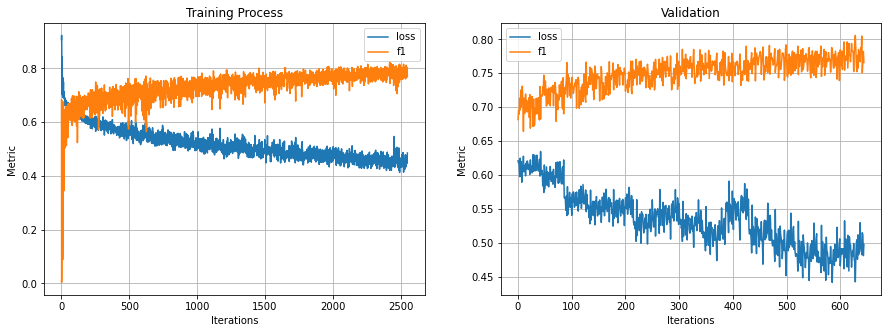

In [61]:
plot_train_and_eval(losses_train, losses_eval, f1s_train, f1s_eval)

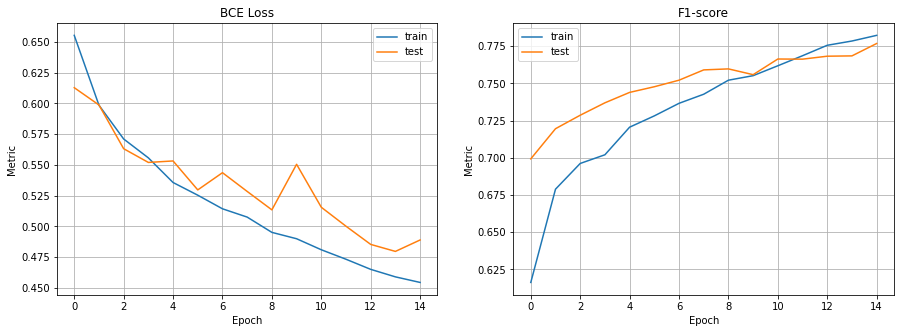

In [62]:
plot_loss_and_f1(losses_train, losses_eval, f1s_train, f1s_eval)

In [63]:
print(
    'WS-CNN с другими размерностями и новым линейным слоем \
(20 эпох): loss = {}, f1 = {}'.format(initial_ws5_loss, initial_ws5_f1))

initial_ws6_loss = np.mean(losses_eval[-1])
initial_ws6_f1 = np.mean(f1s_eval[-1])
print(
    'WS-CNN с другими размерностями и новым линейным слоем \
(15 эпох): loss = {}, f1 = {}'.format(initial_ws6_loss, initial_ws6_f1))

WS-CNN с другими размерностями и новым линейным слоем (20 эпох): loss = 0.47757779235063597, f1 = 0.7779678702354431
WS-CNN с другими размерностями и новым линейным слоем (15 эпох): loss = 0.4889081446237342, f1 = 0.7767636775970459


Да, лишние 5 эпох действительно не давали никакого значимого улучшения, только небольшое.

Лучшая модель -- комбинация всего, что мы попробовали, на 20 эпохах обучения.

In [64]:
print(
    'WS-CNN до улучшений: loss = {}, f1 = {}'.format(
        initial_ws_loss, initial_ws_f1))
print(
    'WS-CNN + dropout, нормализация, weight decay, новый лин. слой: \
loss = {}, f1 = {}'.format(initial_ws5_loss, initial_ws5_f1))

WS-CNN до улучшений: loss = 0.4954905967379725, f1 = 0.7609487771987915
WS-CNN + dropout, нормализация, weight decay, новый лин. слой: loss = 0.47757779235063597, f1 = 0.7779678702354431


Можно еще очень много всего попробовать (другой размер эмбеддингов, еще линейные слои и т.д.), но очень хочется сдать до дедлайна...
### Оценка модели

In [68]:
def predict_and_evaluate(model, iterator):

    model.eval()
    fp, fn, tp, tn = [], [], [], []

    progress_bar = tqdm(total=len(iterator.dataset))

    with torch.no_grad():

        for i, (texts, symbols, ys) in enumerate(iterator):

            preds = model(texts, symbols)  # делаем предсказания на тесте

            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2token[int(token)]
                                 for token in text if token != 0])

                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)

                progress_bar.update()

    progress_bar.close()

    return fp, fn, tp, tn

In [69]:
fp, fn, tp, tn = predict_and_evaluate(ws5_model, val_iterator)

  0%|          | 0/43488 [00:00<?, ?it/s]

#### Accuracy, precision, recall

In [70]:
accuracy = (len(tp) + len(tn)) / (len(tp) + len(fp) + len(tn) + len(fn))
precision = len(tp) / (len(tp) + len(fp))
recall = len(tp) / (len(tp) + len(fn))
f1 = 2 * precision * recall / (precision + recall)

print(
    'Accuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}'.format(
        accuracy, precision, recall, f1))

Accuracy: 0.76595842531273
Precision: 0.7498635313877808
Recall: 0.8088228633543186
F1: 0.7782280908179718


In [76]:
print('Модель из первой части д/з:\n\nAccuracy: 0.7574733259749816\
\nPrecision: 0.7293008828441899\nRecall: 0.830608270302097\
\nF1: 0.7766649020645845')

Модель из первой части д/з:

Accuracy: 0.7574733259749816
Precision: 0.7293008828441899
Recall: 0.830608270302097
F1: 0.7766649020645845


Улучшились значения всех метрик, кроме f1, которая осталась почти такой же.

#### Confusion matrix

In [71]:
cf_matrix = [[len(tn), len(fp)],
             [len(fn), len(tp)]]
cf_matrix

[[15452, 5957], [4221, 17858]]

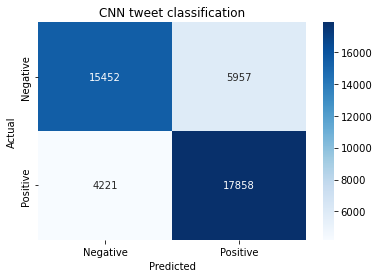

In [72]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('CNN tweet classification')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

plt.show()

Интересно, что первая модель выдавала ложноотрицательный результат в два раза чаще, чем ложноположительный (6.8к против 3.7к), а сейчас эти классы отличаются в полтора раза. Кроме того, улучшилось предсказание отрицательных твитов в целом (а вот положительных немного ухудшилось).
#### Анализ ошибок

In [73]:
def analize_results(fp, fn, tp, tn):
    print('Ложно распознаны как положительные:\n')
    print('\n'.join(random.sample(fp, 10)))
    print('\nВерно распознаны как положительные:\n')
    print('\n'.join(random.sample(tp, 10)))
    print('\nЛожно распознаны как отрицательные:\n')
    print('\n'.join(random.sample(fn, 10)))
    print('\nВерно распознаны как отрицательные:\n')
    print('\n'.join(random.sample(tn, 10)))

In [74]:
analize_results(fp, fn, tp, tn)

Ложно распознаны как положительные:

снег это конечно все круто можно даже сказать романтично но блин холодно
какое там общение если даже разговаривать не хочешь
rt USER USER детское шампанское на меня плохо действует так что я отлично
USER оу надеюсь есть кому тебя до солнечного хотя бы
rt USER USER что я увидел своих кумиров и сфоткался с ними а тебе
USER нет дата не очень
пока готовила салаты успела порезать еще и чуть маникюр не
USER воу воу а как же я ты обидела меня жестоко ты что не рада что познакомилась со мной
USER привет да вроди да работы только нет а деньги нада
услышала сегодня как школьники смеются над в и сама смеялась полдня

Верно распознаны как положительные:

первый раз наверно дал такой огромный ответ на аске пора попробовать сон
rt USER happybirthdaydominichoward ох ты такой взрослый уже с днюхой дорогой d
rt USER спасибо большое за день день рождения прошел на ура
USER ахахахахахаха спасибо я прямо таки какой то неуклюжий
снег снежки снеговик дед мороз елка новог

Здесь мы наблюдаем в целом ту же картину, что и в случае с первой моделью: есть много "ложных друзей модели", т.е. слов, которые вроде бы имеют позитивную окраску, но на самом деле встречаются в негативном твите (и наоборот). И, конечно, спорные с точки зрения человека твиты опять представляют сложность для модели (почему, например, "понимаю в минуты что одиночество сука нет плеча ни ни выспаться ни поржать" -- не отрицательный твит?).

Наверное, так совпало (я выводила всего по 10 твитов), но ошибки второй модели какие-то менее системные (?? я почти уверена, что это совпадение). В целом вывод прежний -- чистить датасет и не ждать от модели чудес. Что касается препроцессинга, его я специально не меняла ни у первой, ни у второй модели, потому что 1) мы уже знаем результат и 2) это слишком просто. Я бы еще попробовала лемматизировать и обучать fasttext-эмбеддинги (на просто токенизированных текстах, которых еще и не очень много, смысла в них оказалось мало.)